In [3]:
import pandas as pd
from top2vec import Top2Vec
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.data_wrangling.load_data import load_political_quotes

# Load quotations from politicians from France, Italy, Germany, Spain and Poland

In [4]:

quotes = []
countries = ['France', 'Italy', 'Germany', 'Spain', 'Poland']
for batch in load_political_quotes(country=countries, chunksize=20000):
    quotes.append(batch)

In [5]:
politician_quotes = pd.concat(quotes, axis=0, ignore_index=True)
politician_quotes = politician_quotes[['quotation', 'speaker', 'country', 'political_alignment', 'date', 'political_party']]
politician_quotes['date'] = pd.to_datetime(politician_quotes['date'])
#politician_quotes = politician_quotes.sample(400000, random_state=1)
politician_quotes

,quotation,speaker,country,political_alignment,date,political_party
0,"A big, fast, athletic guy that just doesn't kn...",Mark Helfrich,Germany,centre-right,2015-08-27 04:42:41,Christian Democratic Union
1,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,Germany,centre-left,2015-12-01 08:47:00,Social Democratic Party of Germany
2,I am convinced that this conflict won't be sol...,Angela Merkel,Germany,centre-right,2015-02-07 10:20:03,Christian Democratic Union
3,action accomplished in the service of excellen...,François Hollande,France,centre-left,2015-03-06 13:14:59,Socialist Party
4,agreed that the E.U. should take further measu...,Angela Merkel,Germany,centre-right,2015-02-20 11:30:03,Christian Democratic Union
...,...,...,...,...,...,...
451124,The most important step in Libya now is the me...,Angela Merkel,Germany,centre-right,2020-01-24 16:30:48,Christian Democratic Union
451125,"very frank, very constructive and, I think ver...",Edouard Philippe,France,centre-right,2020-01-10 18:17:55,Union for a Popular Movement
451126,We have also touched on barriers related to ho...,Angela Merkel,Germany,centre-right,2020-02-06 04:12:00,Christian Democratic Union
451127,We have to create our own capability that best...,Emmanuel Macron,France,centre-left,2020-02-17 14:29:14,Socialist Party


# Run Top2Vec
### Configure Top2Vec

Here we configure Top2Vec and prepare the data. Top2Vec wants the documents and the ids as a list...

In [6]:
# SAMPLING
sampled_politician_quotes = politician_quotes.sample(130000, random_state=1)
documents_for_top2vec = sampled_politician_quotes['quotation'].tolist()
ids_for_top2vec  = sampled_politician_quotes.index.tolist()

excluded_indices = politician_quotes.index.isin(ids_for_top2vec)
not_sampled_politician_quotes = politician_quotes[~excluded_indices]
docs_for_top2vec_not_sampled = not_sampled_politician_quotes['quotation'].tolist()
ids_for_top2vec_not_sampled = not_sampled_politician_quotes.index.tolist()

Here we configure the dimensionality reduction(UMAP) and the clustering(HDBSCAN) steps.

In [ ]:
umap_args = {'n_neighbors': 15,
             'n_components': 15,
             'metric': 'cosine'}
hdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'#,'core_dist_n_jobs': 1
               }

The speed option chooses a preconfiguration of for doc2vec. Here we used the quickest preset. But this we could also  modify later in the top2vec code manually to get optimal results.

### Execute the pipeline(Doc2Vec, UMAP, HDBSCAN, AssignToTopics)

In [ ]:
model = Top2Vec(documents_for_top2vec, document_ids=ids_for_top2vec, speed='learn',
                umap_args=umap_args, hdbscan_args=hdbscan_args, workers=8)

... and save the model for later.

In [ ]:
model.save("all-years-doc2vec-sampled-without-uk")

### Collect the quotes in the topics of interest

In [7]:
# Load trained model
top2vec_model = Top2Vec.load("all-years-doc2vec-sampled-without-uk")

# Add documents not trained
top2vec_model.add_documents(docs_for_top2vec_not_sampled, doc_ids=ids_for_top2vec_not_sampled)


In [8]:
# Functions for visualization

def filter_quotes_by_custom_topic(dataframe, top2vec_model, topic_keywords, similarity_threshold = 0.22):
    doc_words, document_scores, document_ids = top2vec_model.search_documents_by_keywords(keywords=topic_keywords, num_docs=len(dataframe))
    positions = np.argwhere(document_scores > similarity_threshold).flatten()
    print("There are %d quotes above the threshold %.2f for the topic with the following keywords: %s" % (len(positions), similarity_threshold, topic_keywords[0]), end='')
    for keyword in topic_keywords[1:]:
        print(", %s" % keyword, end='')
    print(".")
    return dataframe[dataframe.index.isin(document_ids[positions])]

def filter_quotes_by_existent_topic(dataframe, top2vec_model, topic_id, similarity_threshold = 0.25):
    _, document_scores, document_ids = top2vec_model.search_documents_by_topic(topic_num=48, num_docs=len(dataframe))
    positions = np.argwhere(document_scores > similarity_threshold).flatten()
    print("There are %d quotes above the threshold %.2f for the topic with ID %s." % (len(positions), similarity_threshold, topic_id))
    return dataframe[dataframe.index.isin(positions)]

In [9]:
immigration_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["immigration", "migrants"])
europe_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["european"])
discrimination_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["discrimination", "racism", "gender", "equality"])
drugs_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["cannabis", "protectionism", "drug"])
climate_change_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["climate", "change", "emissions"])
russia_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["russia", "putin"])
covid_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["coronavirus"])
terrorism_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["terrorism"])

There are 4101 quotes above the threshold 0.22 for the topic with the following keywords: immigration, migrants.
There are 3737 quotes above the threshold 0.22 for the topic with the following keywords: european.
There are 3081 quotes above the threshold 0.22 for the topic with the following keywords: discrimination, racism, gender, equality.
There are 715 quotes above the threshold 0.22 for the topic with the following keywords: cannabis, protectionism, drug.
There are 3896 quotes above the threshold 0.22 for the topic with the following keywords: climate, change, emissions.
There are 2849 quotes above the threshold 0.22 for the topic with the following keywords: russia, putin.
There are 356 quotes above the threshold 0.22 for the topic with the following keywords: coronavirus.
There are 4576 quotes above the threshold 0.22 for the topic with the following keywords: terrorism.


In [10]:
# Save topics
immigration_quotes.to_csv('immigration_quotes')
europe_quotes.to_csv('europe_quotes')
discrimination_quotes.to_csv('immigration_quotes')
drugs_quotes.to_csv('discrimination_quotes')
climate_change_quotes.to_csv('drugs_quotes')
russia_quotes.to_csv('russia_quotes')
covid_quotes.to_csv('covid_quotes')
terrorism_quotes.to_csv('terrorism_quotes')

# Topic analysis

### Visualization function

Here we define some functions that will be needed for the visualization of the results.

In [11]:
# Distribution over time
def show_time_distribution(topic_name, df, country = None):
    series = df["date"].dt.strftime('%Y-%b')
    series = series.groupby(series).count()
    date_range = pd.date_range('2015-01-01','2020-04-01',
              freq='MS').strftime("%Y-%b")
    series = series.reindex(date_range, fill_value=0)

    visualized_df = pd.DataFrame({'dates': series.index,
                        'counts': series.values
                       }, columns = ['dates','counts'])


    fig, ax = plt.subplots(figsize = (20,12))
    sns.barplot(x = "dates", y = "counts", data = visualized_df,
                      ci = None, ax=ax)
    ax.set_xticklabels(labels=visualized_df['dates'], rotation=45, ha='right')
    # Add title and axis names

    plt.xlabel('Year - Month')
    plt.ylabel('Number of quotes')
    if country is None:
        plt.title('%s - Distribution of quotes over time in all countries' % topic_name)
    else:
        plt.title('%s - Distribution of quotes over time in %s' % (topic_name, country))
    plt.show()


def show_time_distribution_per_country(topic_name, df):
    df2 = df.copy(deep=True)
    df2["date"] = df["date"].dt.strftime('%Y-%b')
    date_range = pd.date_range('2015-01-01','2020-04-01',
              freq='MS').strftime("%Y-%b").tolist()

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
    palette = sns.color_palette("colorblind", 12)
    g = sns.FacetGrid(df2, palette=palette, row="country", row_order=countries, hue="country", aspect=15, height=2, sharey=False)
    g.map_dataframe(sns.countplot, x="date", order=date_range, alpha=0.8)
    g.set(yticks=[], yticklabels=[], ylabel=None, xlabel="Date")
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.04, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "country")
    g.fig.subplots_adjust(hspace=-.1)
    g.set_titles("")
    g.despine(left=True)
    plt.suptitle('%s - Number of quotes over time per country' % topic_name, y=0.98)
    plt.xlabel('Date')

# Distribution of political orientation
def show_political_orientation_distribution(topic_name, df, country = None):
    political_alignments = ['far-left', 'radical left', 'left-wing', 'centre-left',
                        'centrism', 'centre-right', 'right-wing', 'far-right',
                        'national conservatism', 'nationalism', 'liberalism', 'Third Way', 'syncretic politics', None]

    series = df.groupby(['political_alignment'])['political_alignment'].count()
    series = series.reindex(political_alignments)
    series = series.dropna()
    visualized_df = pd.DataFrame({'political_alignment': series.index,
                        'counts': series.values
                       }, columns = ['political_alignment','counts'])
    fig = sns.catplot(x='political_alignment', y='counts', kind="bar", palette="colorblind", data=visualized_df)
    plt.xlabel('Political alignment')
    plt.ylabel('Number of quotes')
    if country is None:
        plt.title('%s - Distribution of quotes over political alignments in all countries' % topic_name)
    else:
        plt.title('%s - Distribution of quotes over political alignments in %s' % (topic_name, country))
    fig.set_xticklabels(labels=visualized_df['political_alignment'], rotation=45, ha='right')
    plt.show()

def show_political_orientation_distribution_per_country(topic_name, df):
    dataset_political_alignments = df['political_alignment'].unique().tolist()
    political_alignments = ['far-left', 'radical left', 'left-wing', 'centre-left',
                        'centrism', 'centre-right', 'right-wing', 'far-right',
                        'national conservatism', 'nationalism', 'liberalism', 'Third Way', 'syncretic politics', None]
    political_alignments = [entry for entry in political_alignments if entry in dataset_political_alignments]
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
    palette = sns.color_palette("colorblind", 12)
    g = sns.FacetGrid(df, palette=palette, row="country", row_order=countries, hue="country", aspect=8, height=2, sharey=False)
    g.map_dataframe(sns.countplot, x="political_alignment", order=political_alignments)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.1, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "country")
    g.set_titles("")
    g.set(yticks=[], yticklabels=[], ylabel=None, xlabel="Political alignment")
    g.despine( left=True)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    #g.set_xticklabels(labels=political_alignments, rotation=45, ha='right')
    plt.suptitle('%s - Number of quotes over political alignments in all countries' % topic_name)


# Distribution of top speakers
def show_top_k_speakers(topic_name, df, country = None, k=10):
    # Filtered top 10 speakers
    if country is None:
        series = df['speaker'] + ' / ' + df['political_party'] + ' (' + df['country'] + ')'
    else:
        series = df['speaker'] + ' / ' + df['political_party']

    series = series.groupby(series).count()
    visualized_df = pd.DataFrame({'speaker': series.index,
                        'counts': series.values
                       }, columns = ['speaker','counts'])
    visualized_df = visualized_df.sort_values('counts', ascending=False).head(k)
    fig, ax = plt.subplots(figsize = (14,10))
    sns.barplot(x="speaker", y="counts", data=visualized_df,
                      ci = None, ax=ax)
    ax.set_xticklabels(labels=visualized_df['speaker'], rotation=60, ha='right')
    plt.xlabel('Speaker / Party (Country)')
    plt.ylabel('Number of quotes')
    if country is None:
        plt.title('%s - Top speakers in all countries' % topic_name)
    else:
        plt.title('%s - Top speakers in %s' % (topic_name, country))
    plt.show()



def show_top_k_speakers_per_country(topic_name, df, country, k=10):
    country_df = df[df['country'] == country]
    show_top_k_speakers(topic_name, country_df, country = country, k = k)



## Immigration

### Distribution over time in all countries

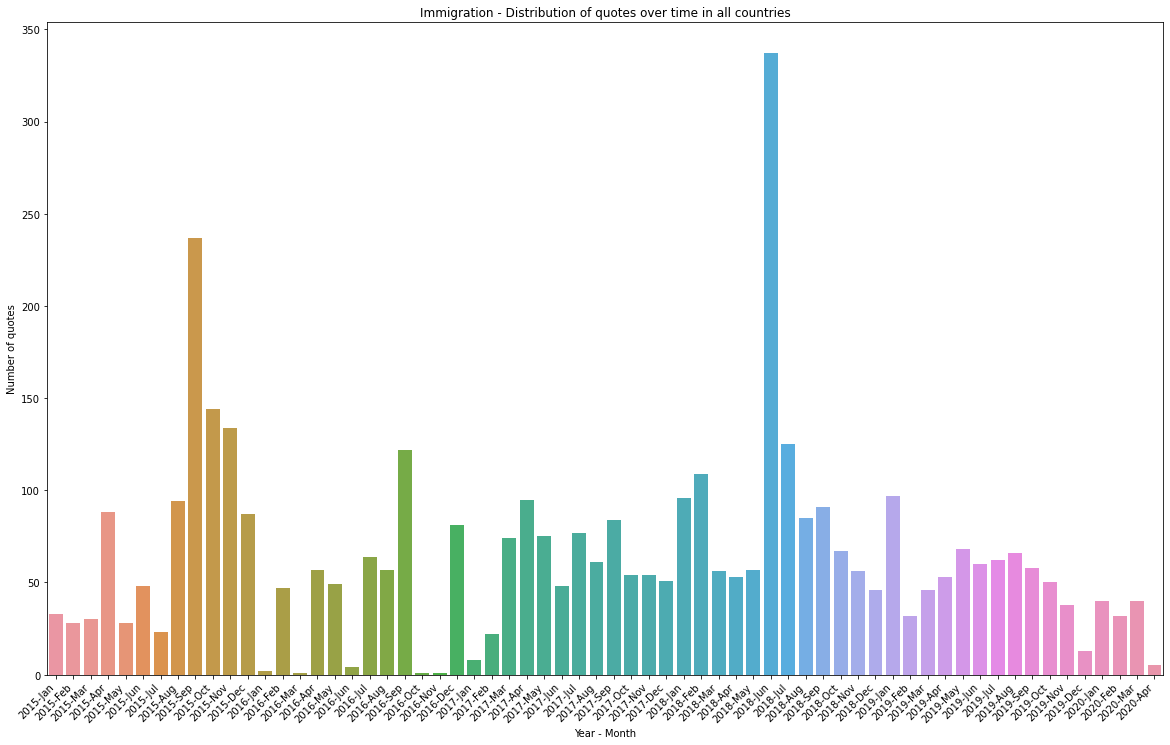

In [12]:
topic_name = 'Immigration'
df = immigration_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

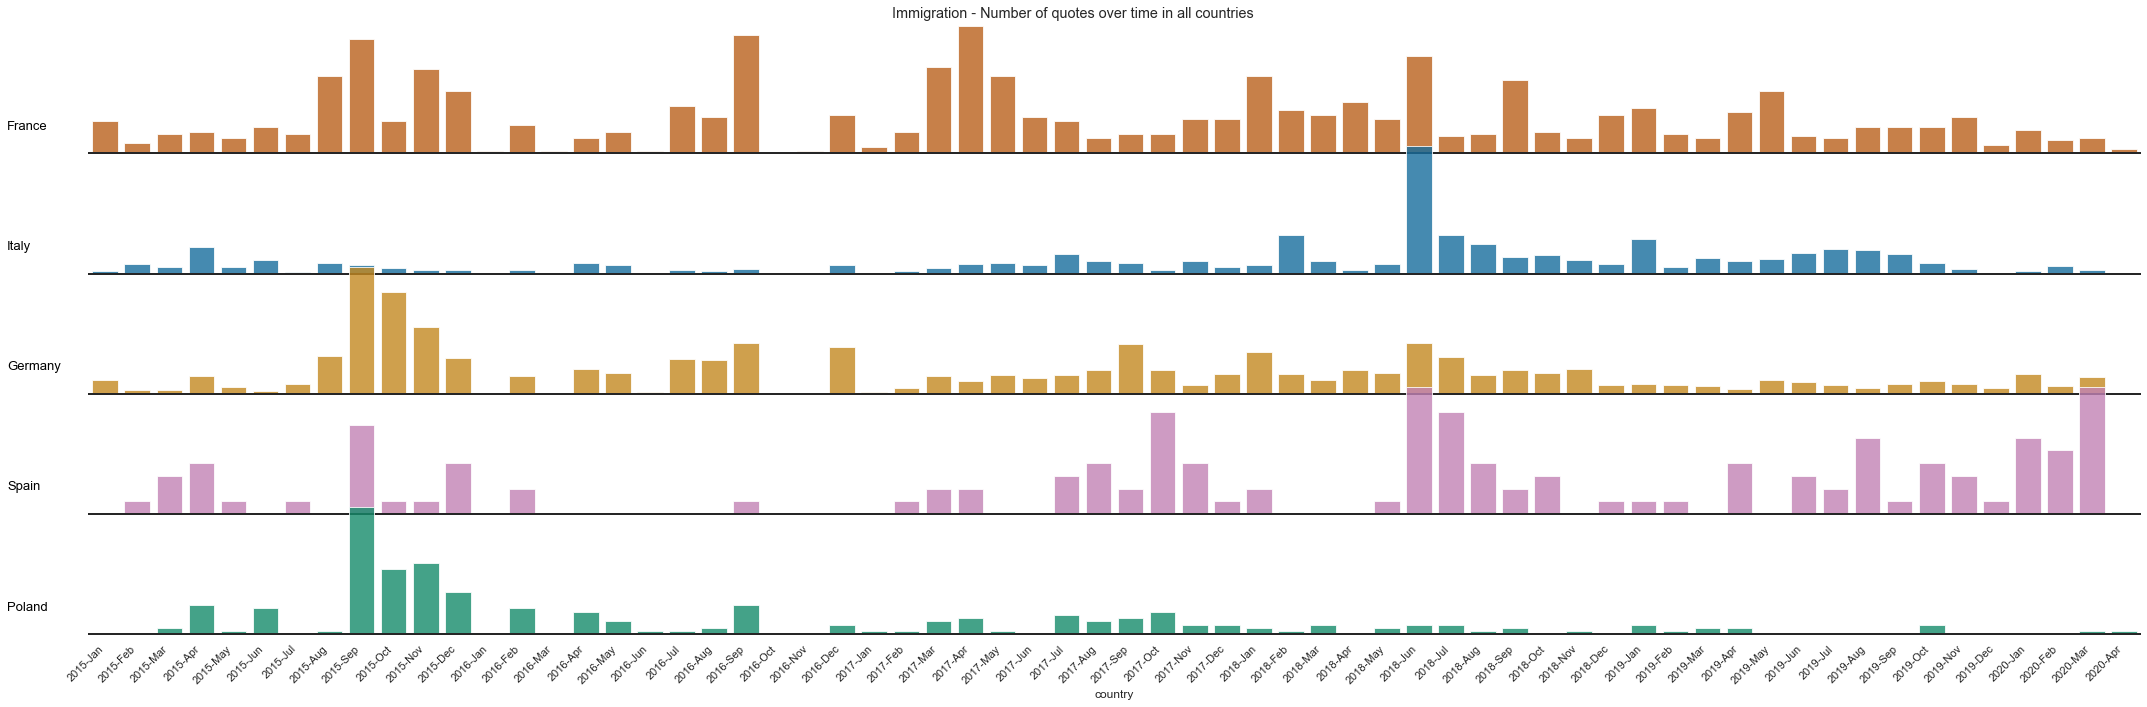

In [13]:
show_time_distribution_per_country(topic_name, df)

### Distribution over political alignments

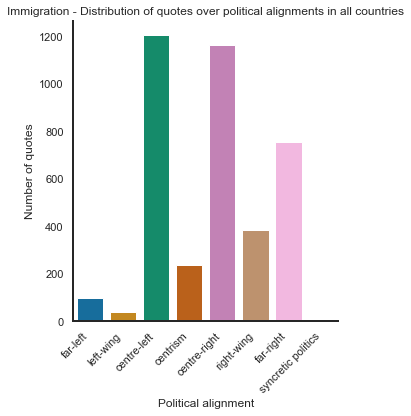

In [14]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

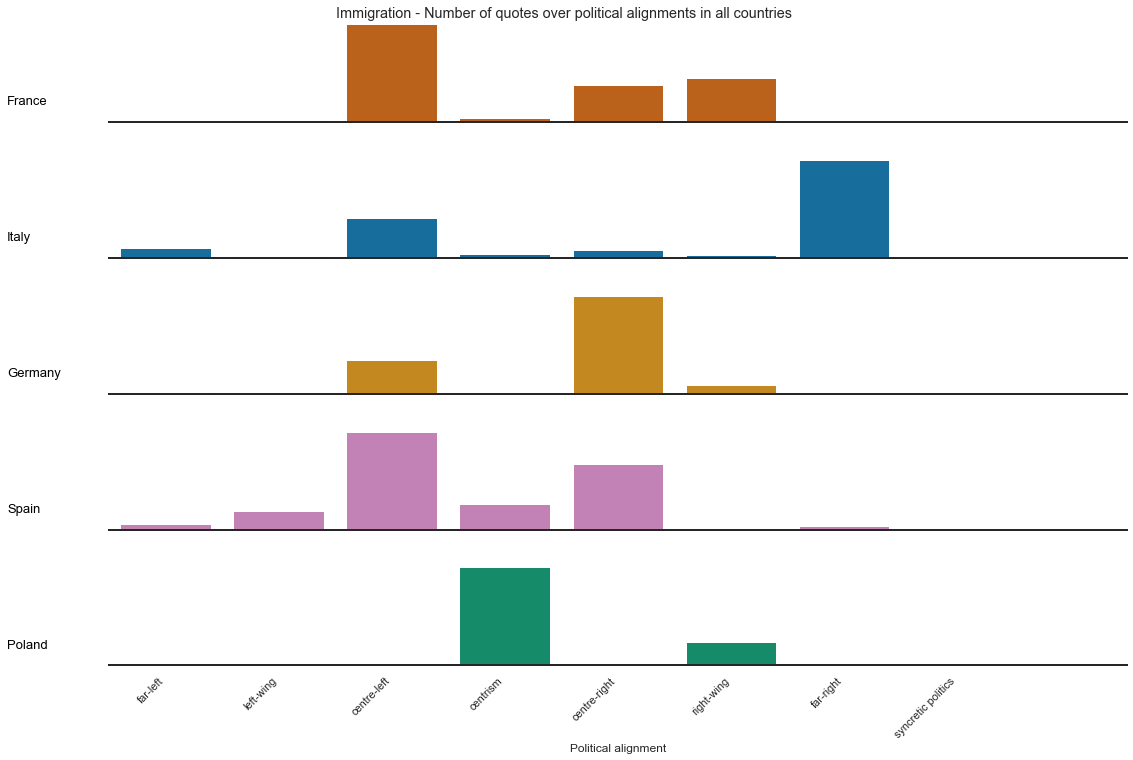

In [15]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

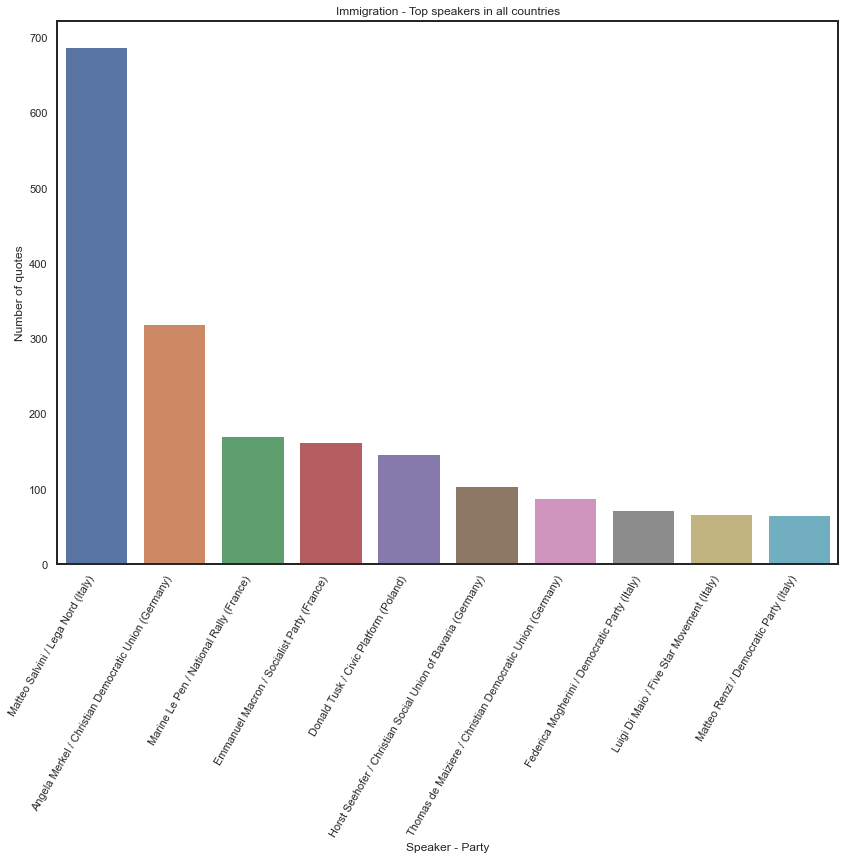

In [16]:
show_top_k_speakers(topic_name, df)

## European Union

### Distribution over time in all countries

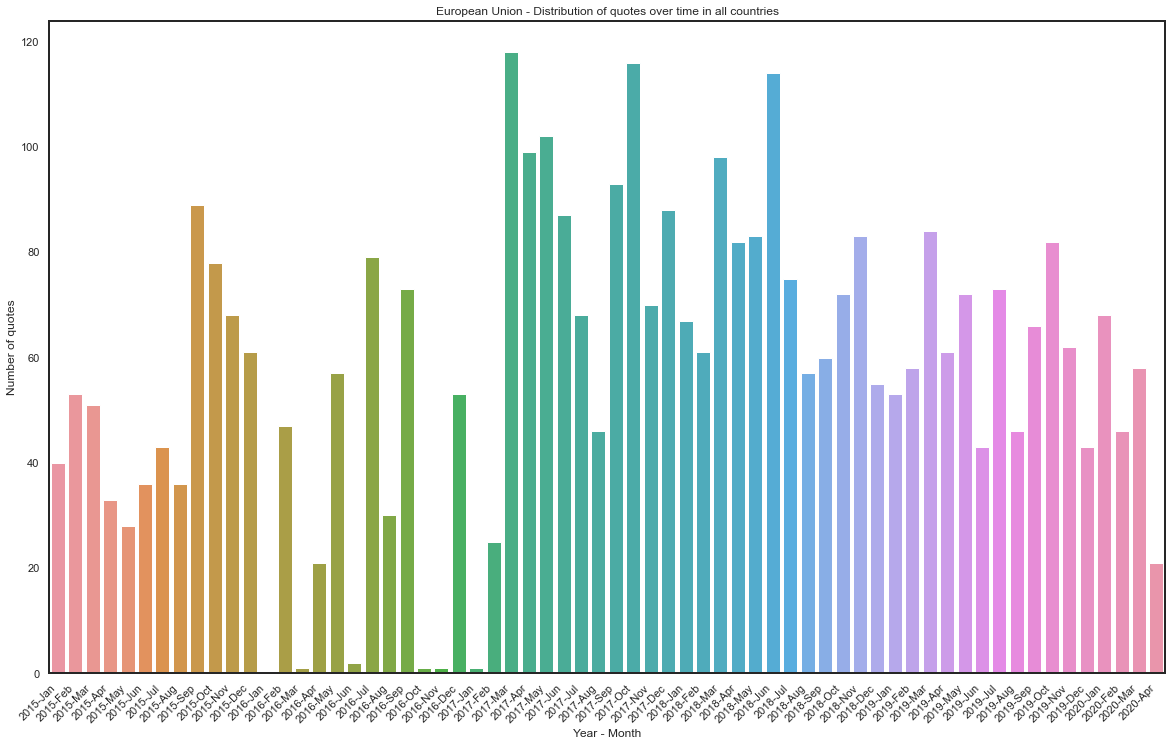

In [17]:
topic_name = 'European Union'
df = europe_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

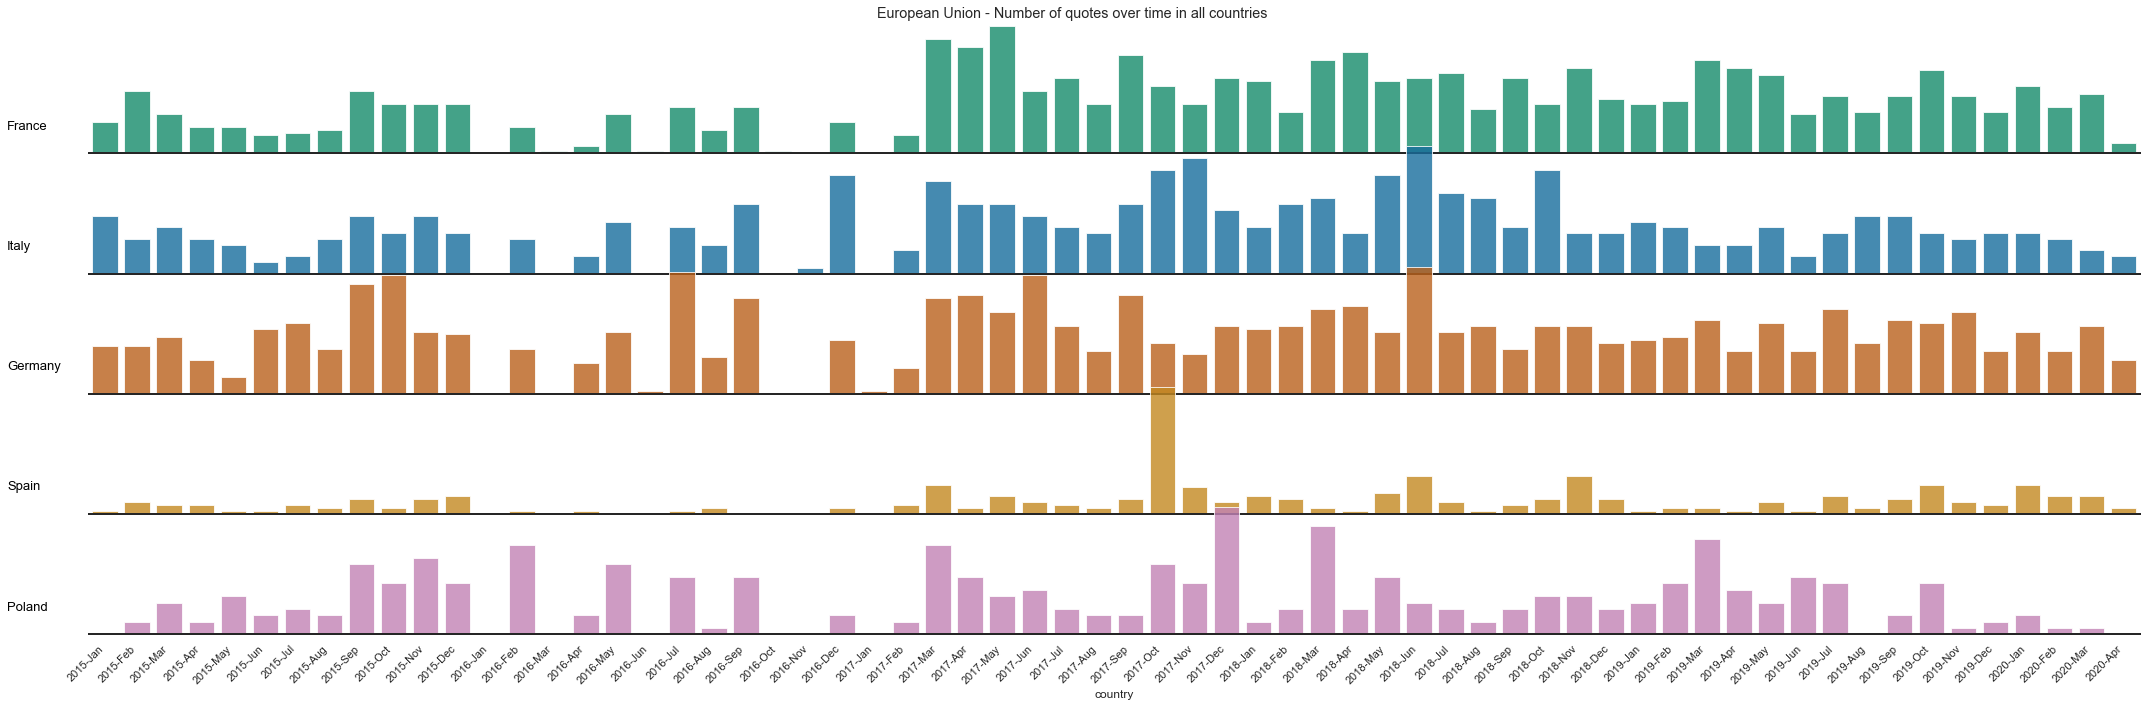

In [18]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

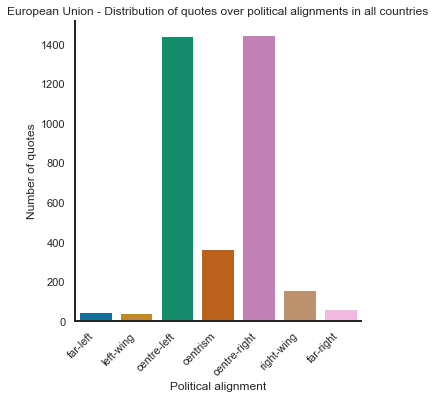

In [19]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

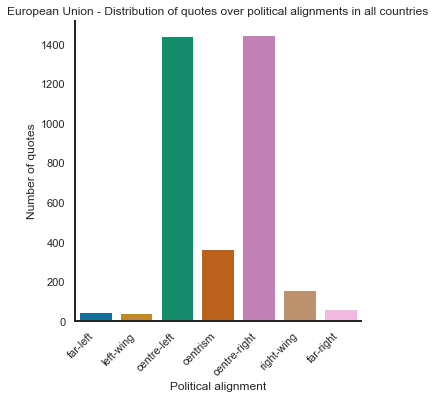

In [20]:
show_political_orientation_distribution(topic_name, df)

### Top speakers in all countries

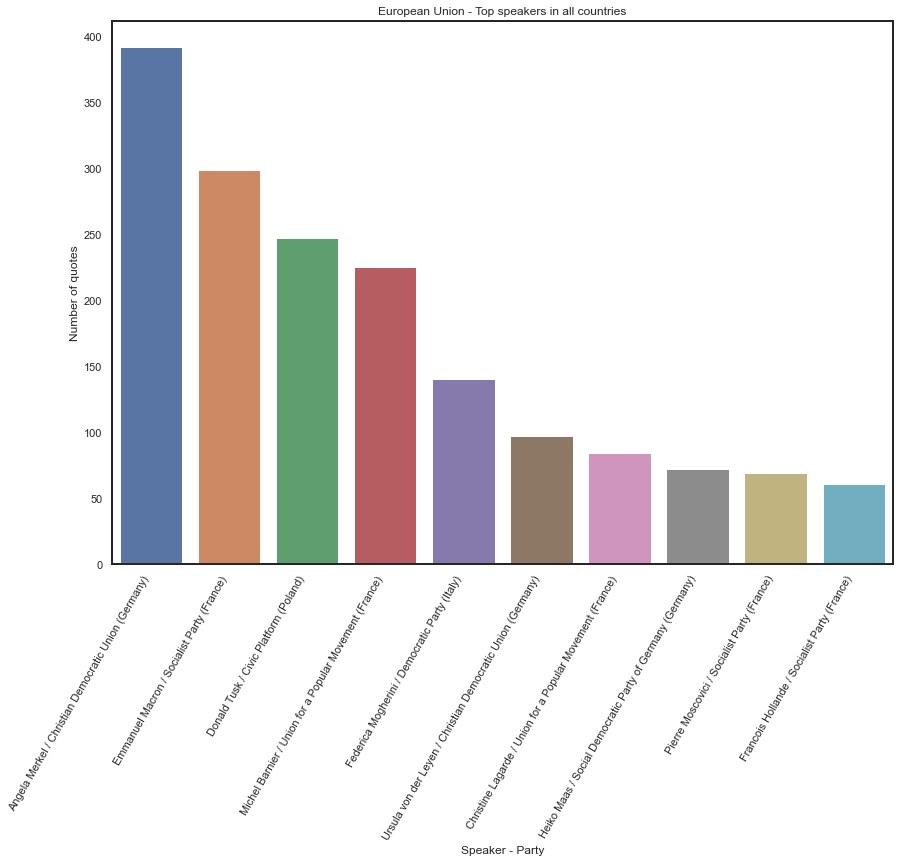

In [21]:
show_top_k_speakers(topic_name, df)


## Discriminations

### Distribution over time in all countries

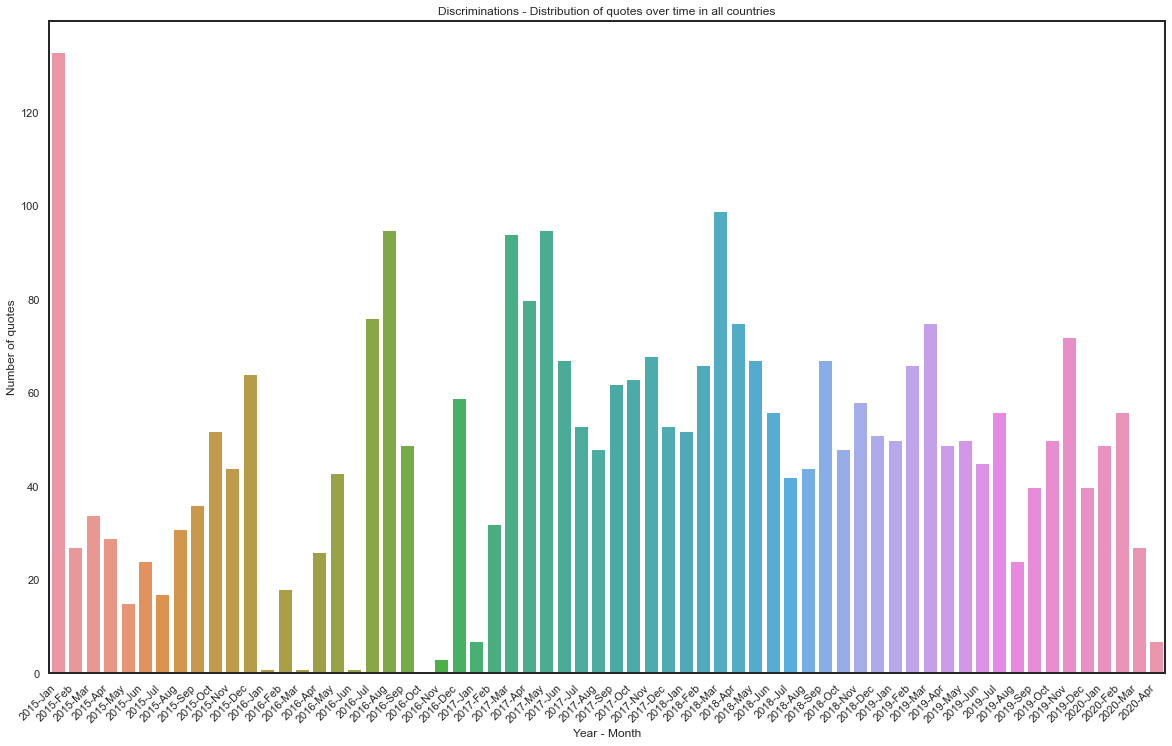

In [22]:
topic_name = 'Discriminations'
df = discrimination_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

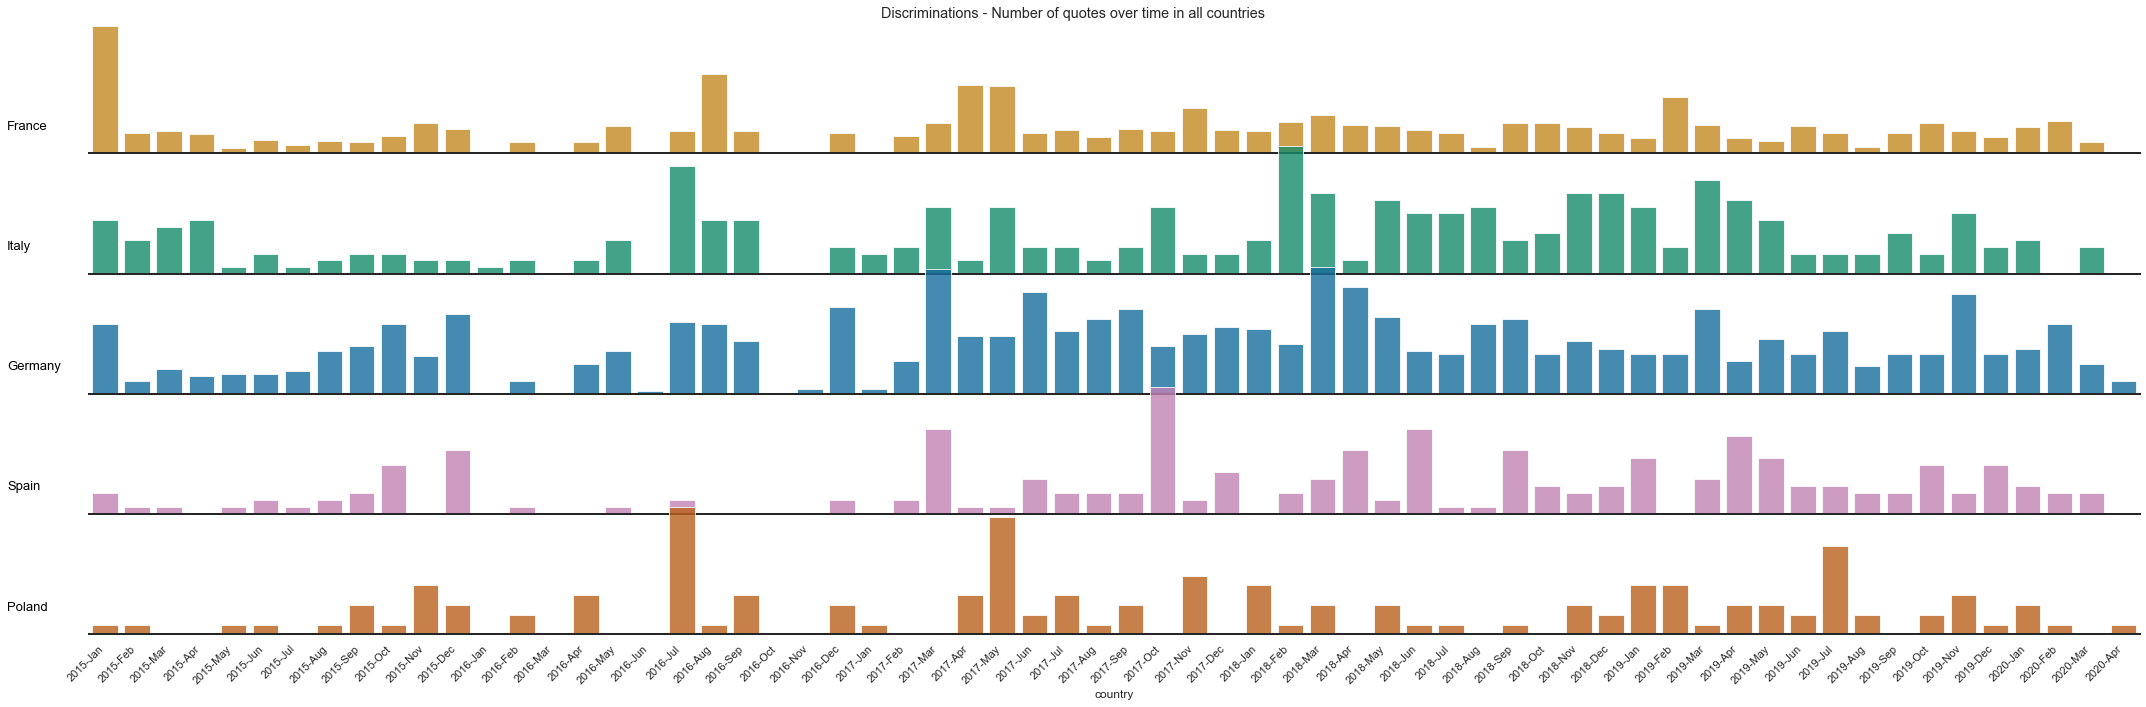

In [23]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

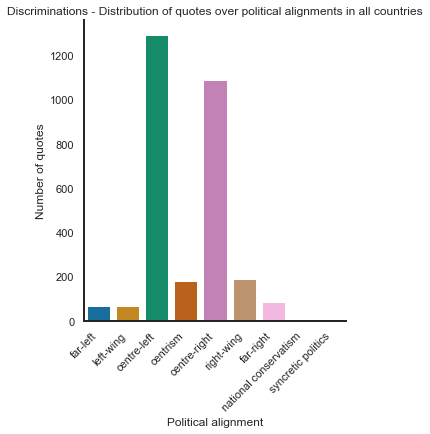

In [24]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

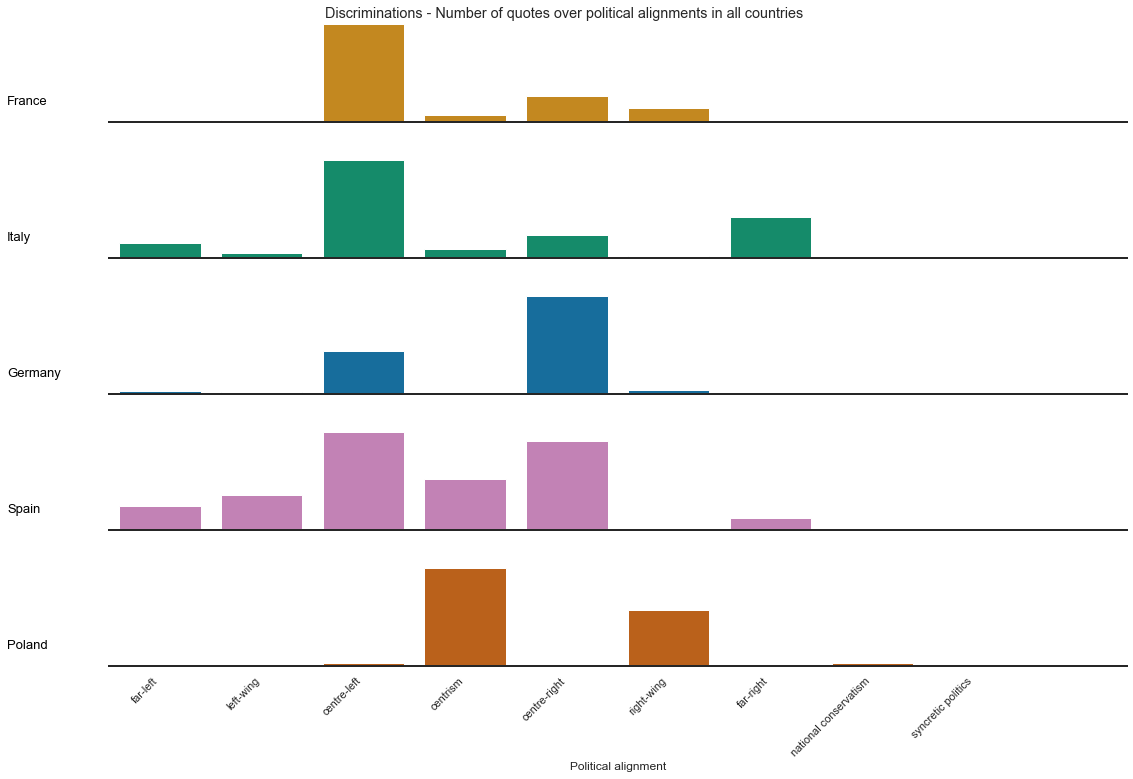

In [25]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

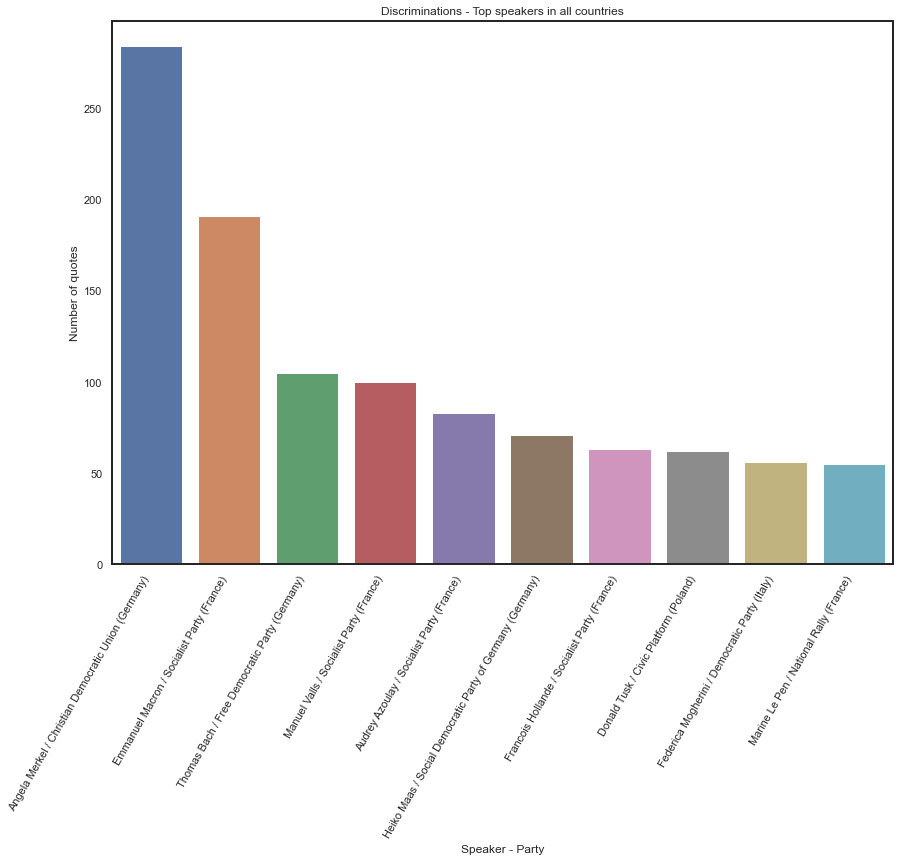

In [26]:
show_top_k_speakers(topic_name, df)

## Drugs

### Distribution over time in all countries

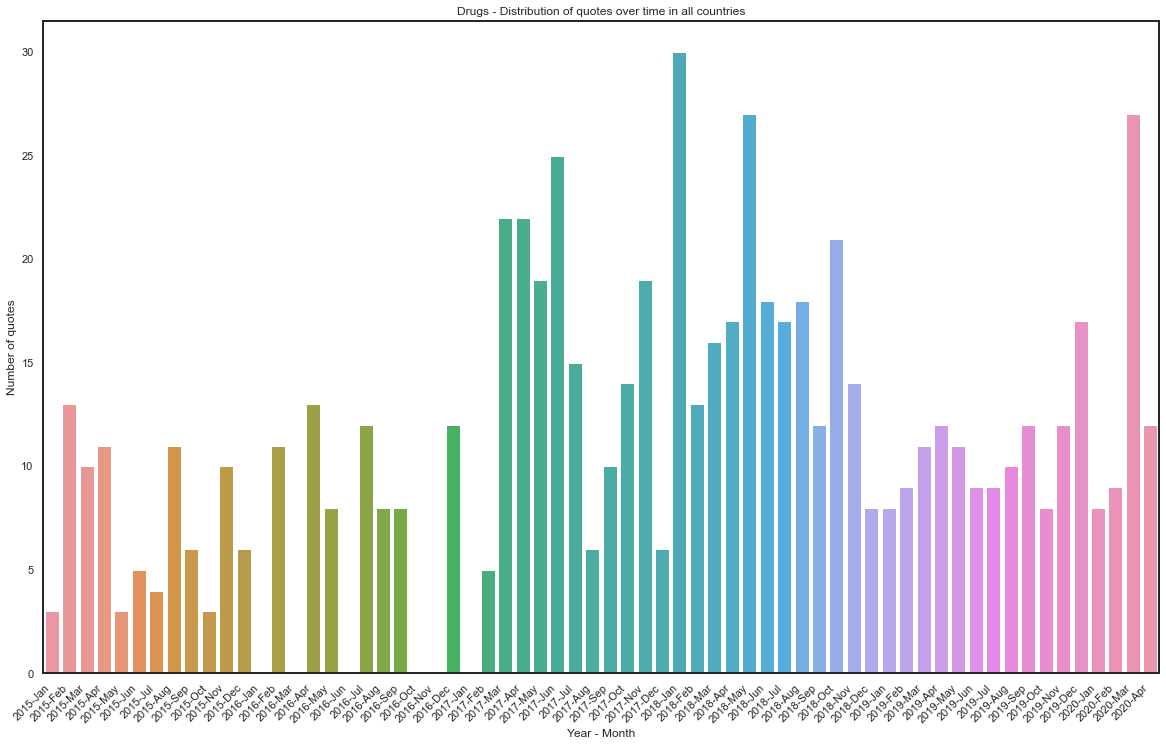

In [27]:
topic_name = 'Drugs'
df = drugs_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

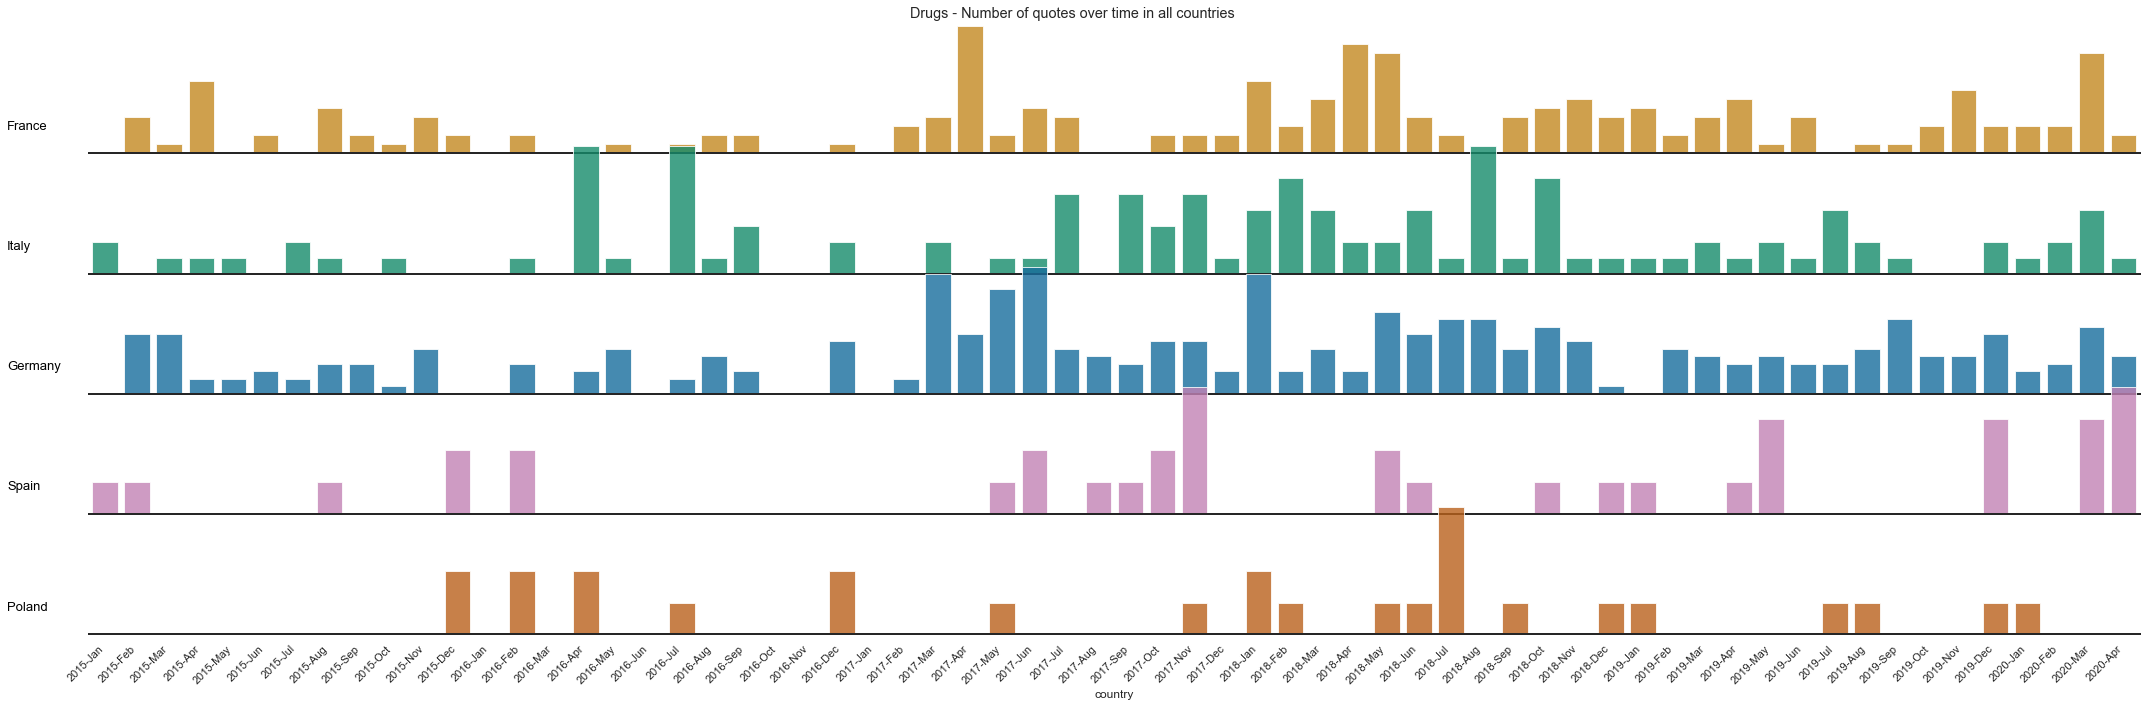

In [28]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

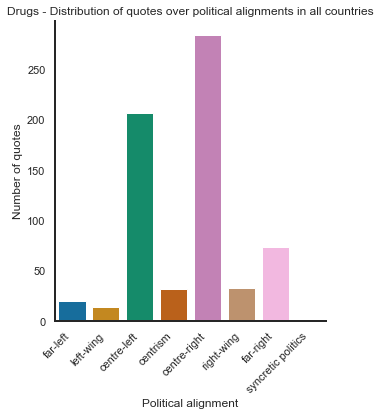

In [29]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

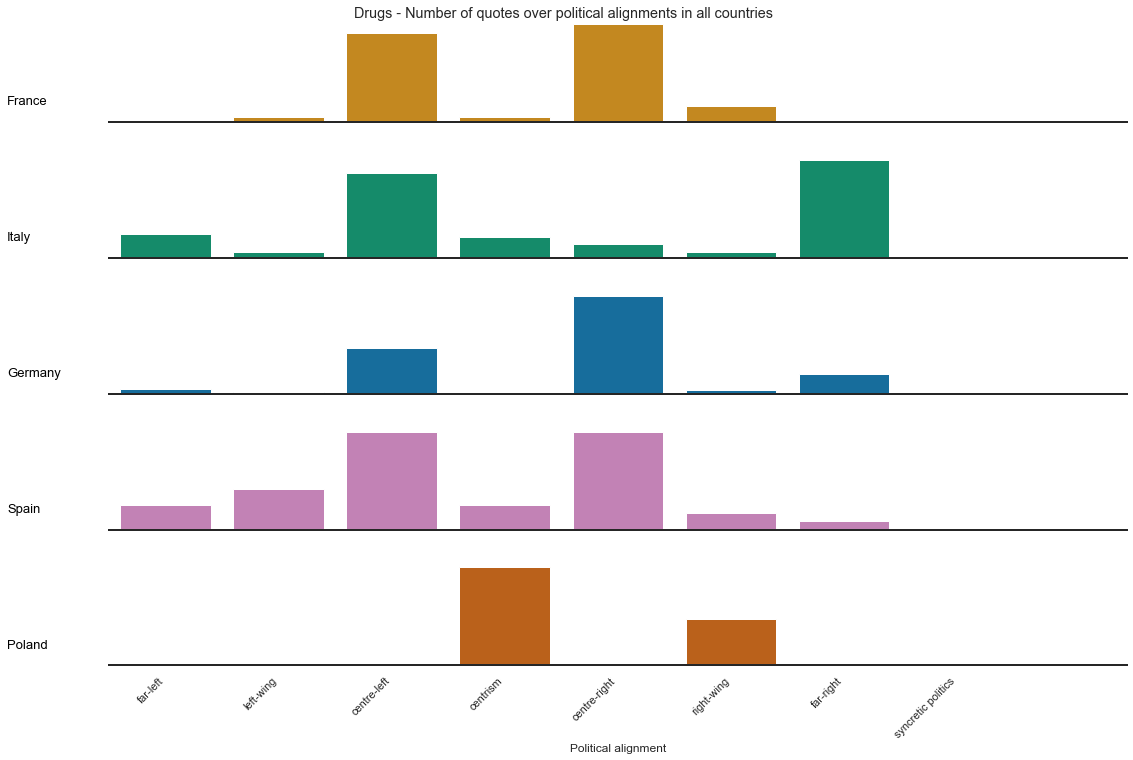

In [30]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

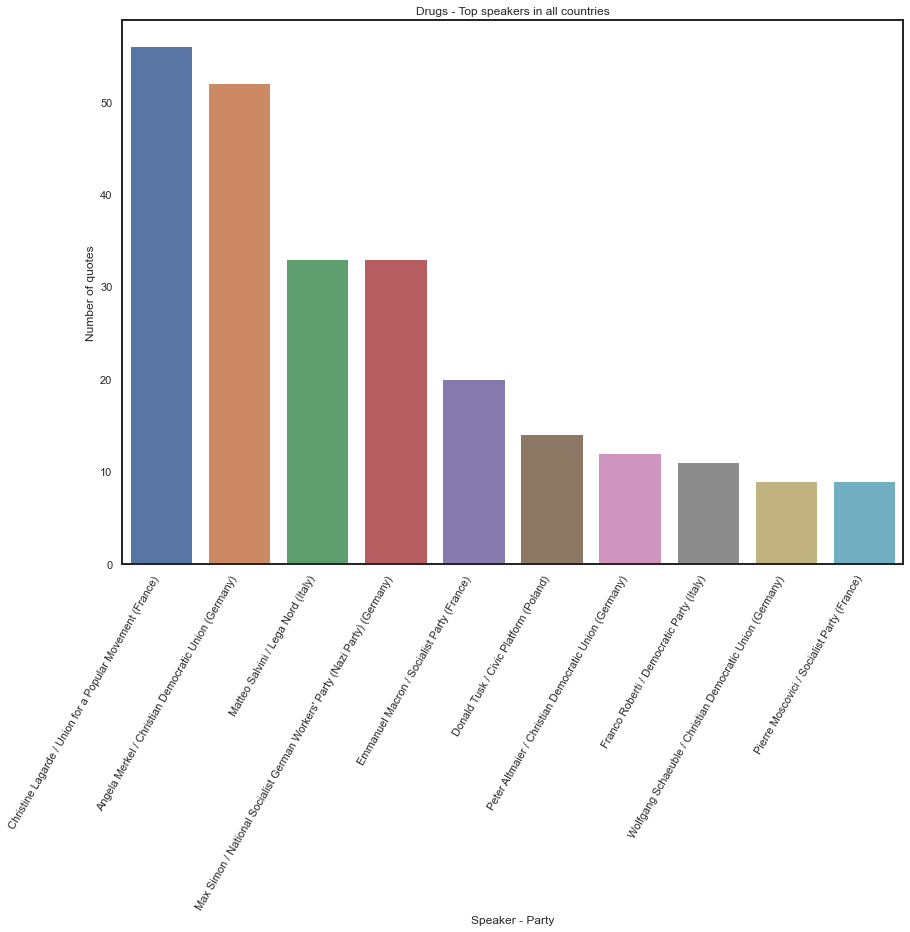

In [31]:
show_top_k_speakers(topic_name, df)


## Climate change

### Distribution over time in all countries

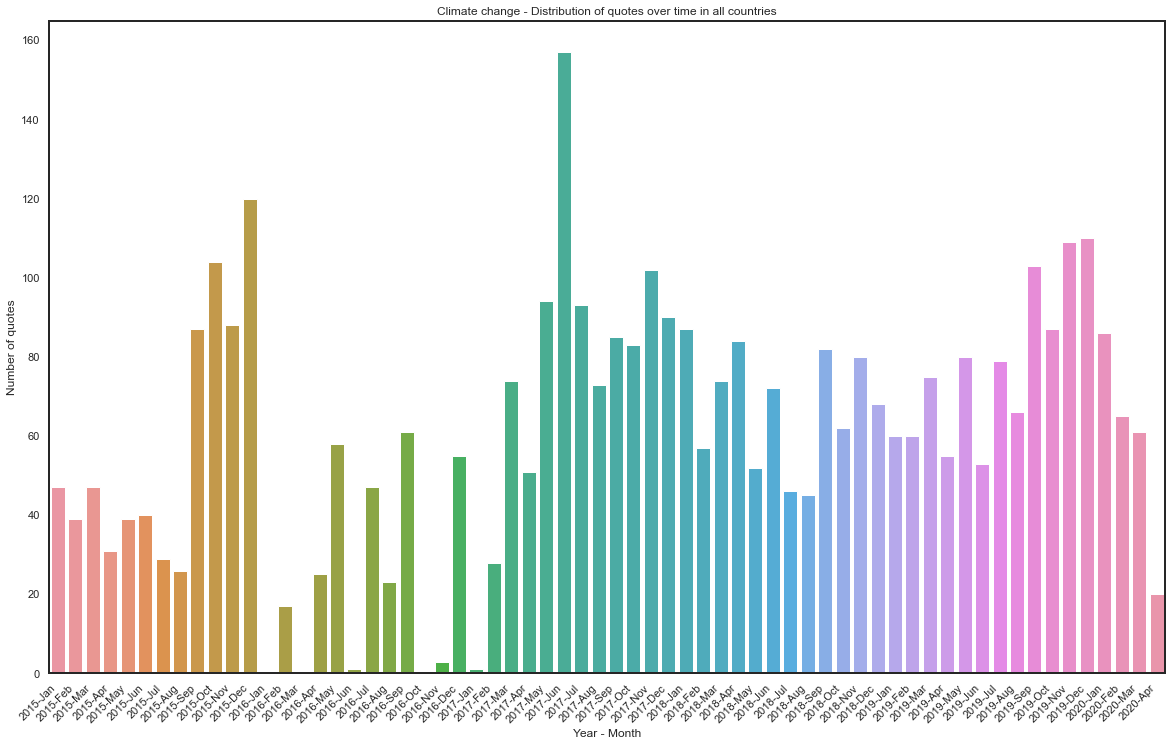

In [32]:
topic_name = 'Climate change'
df = climate_change_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

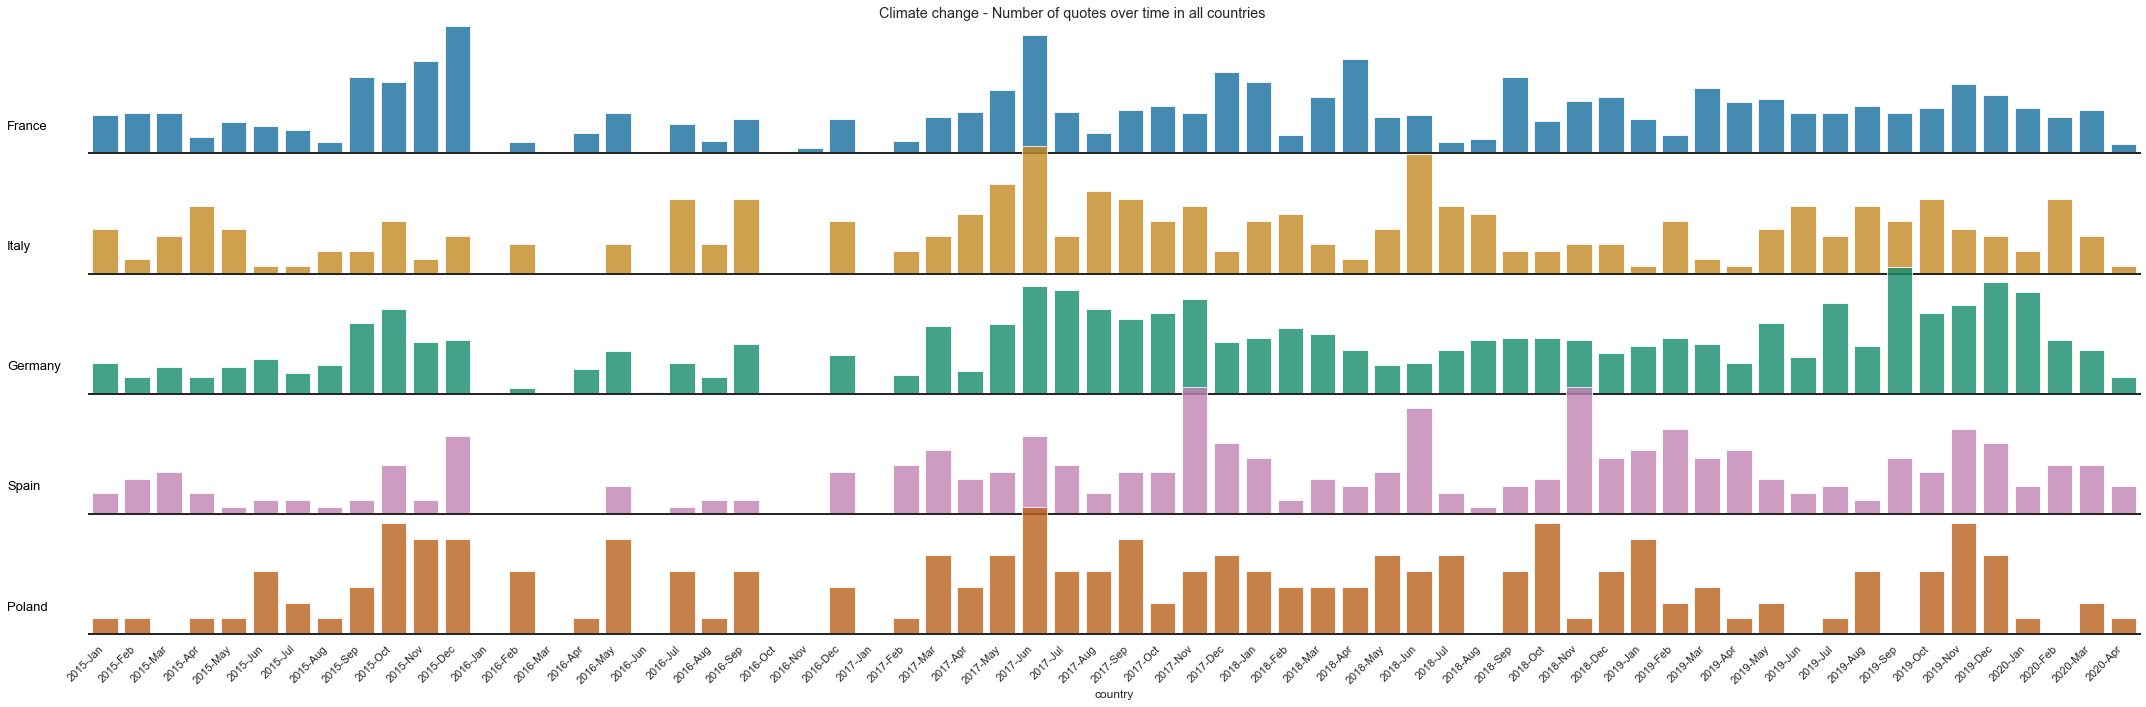

In [33]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

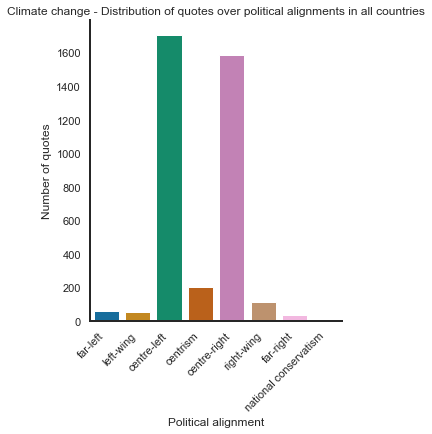

In [34]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

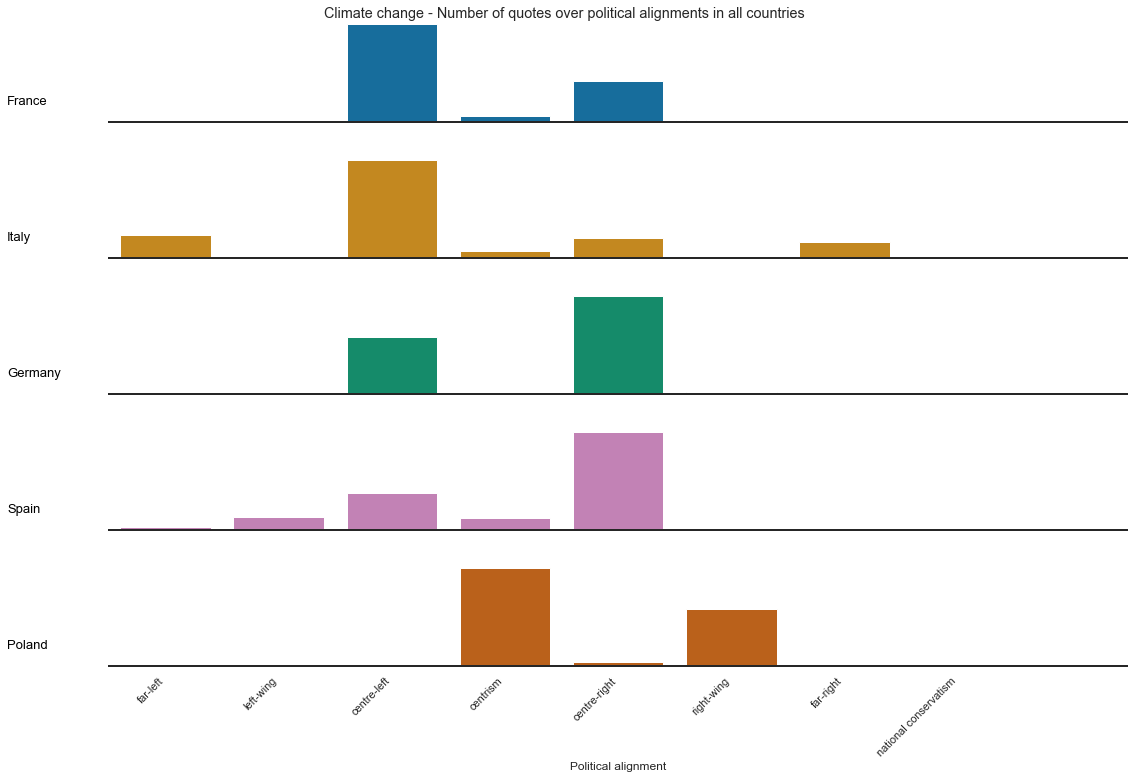

In [35]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

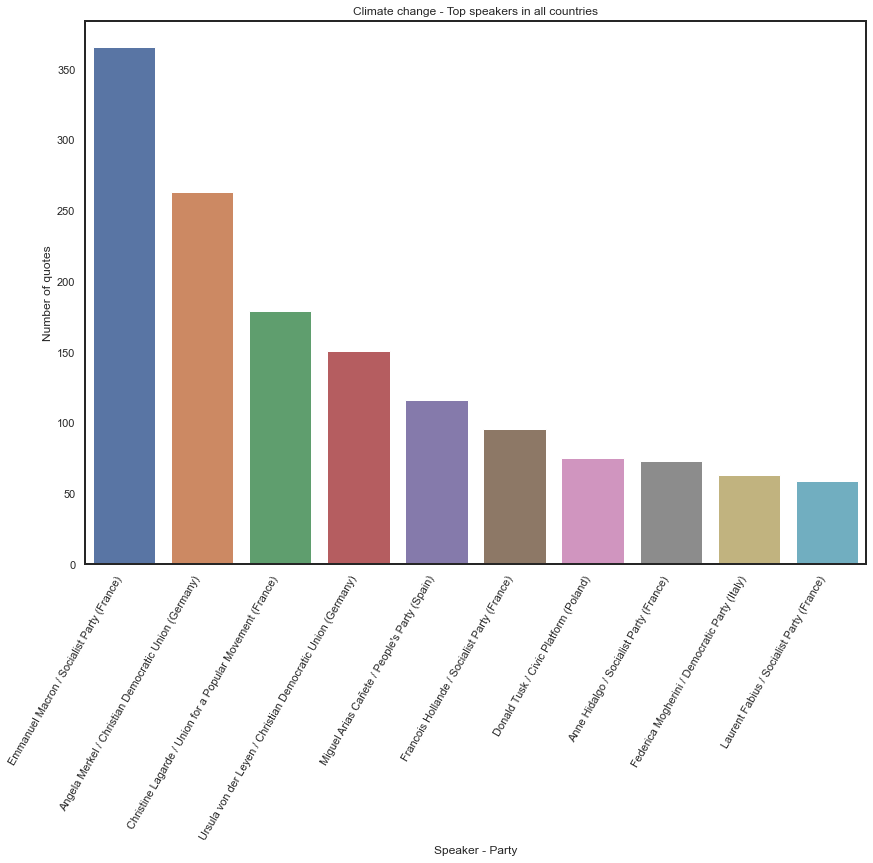

In [36]:
show_top_k_speakers(topic_name, df)

## Russia

### Distribution over time in all countries

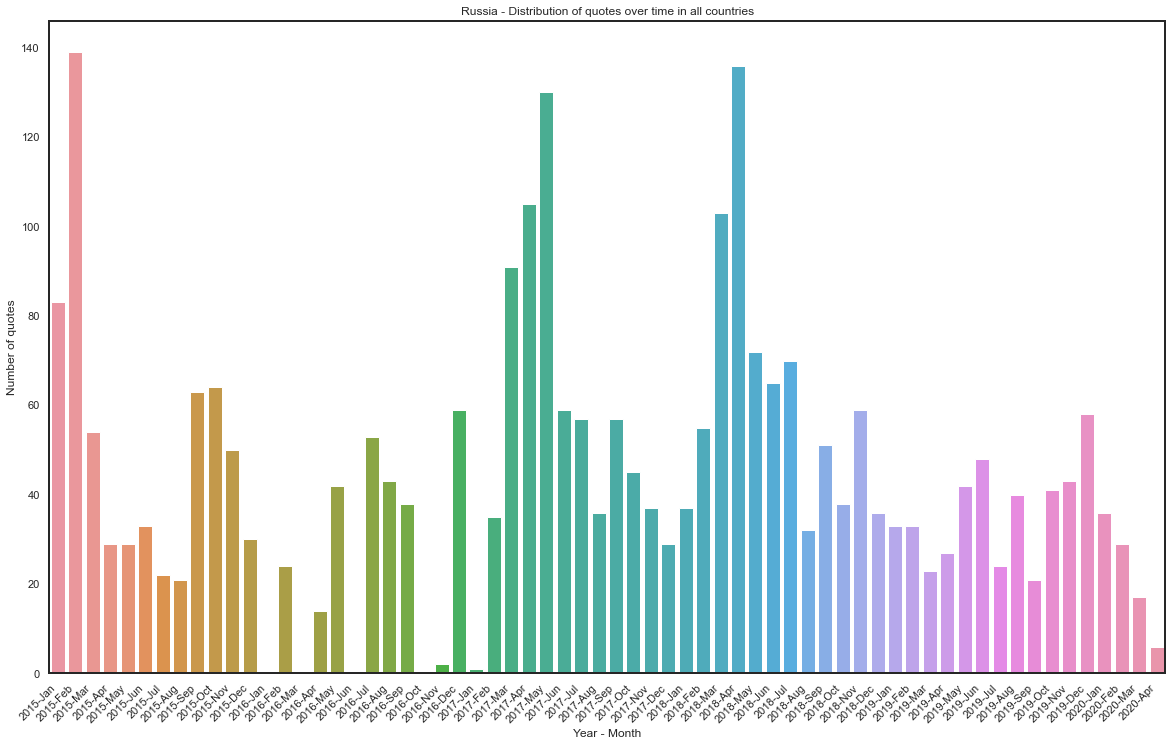

In [37]:
topic_name = 'Russia'
df = russia_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

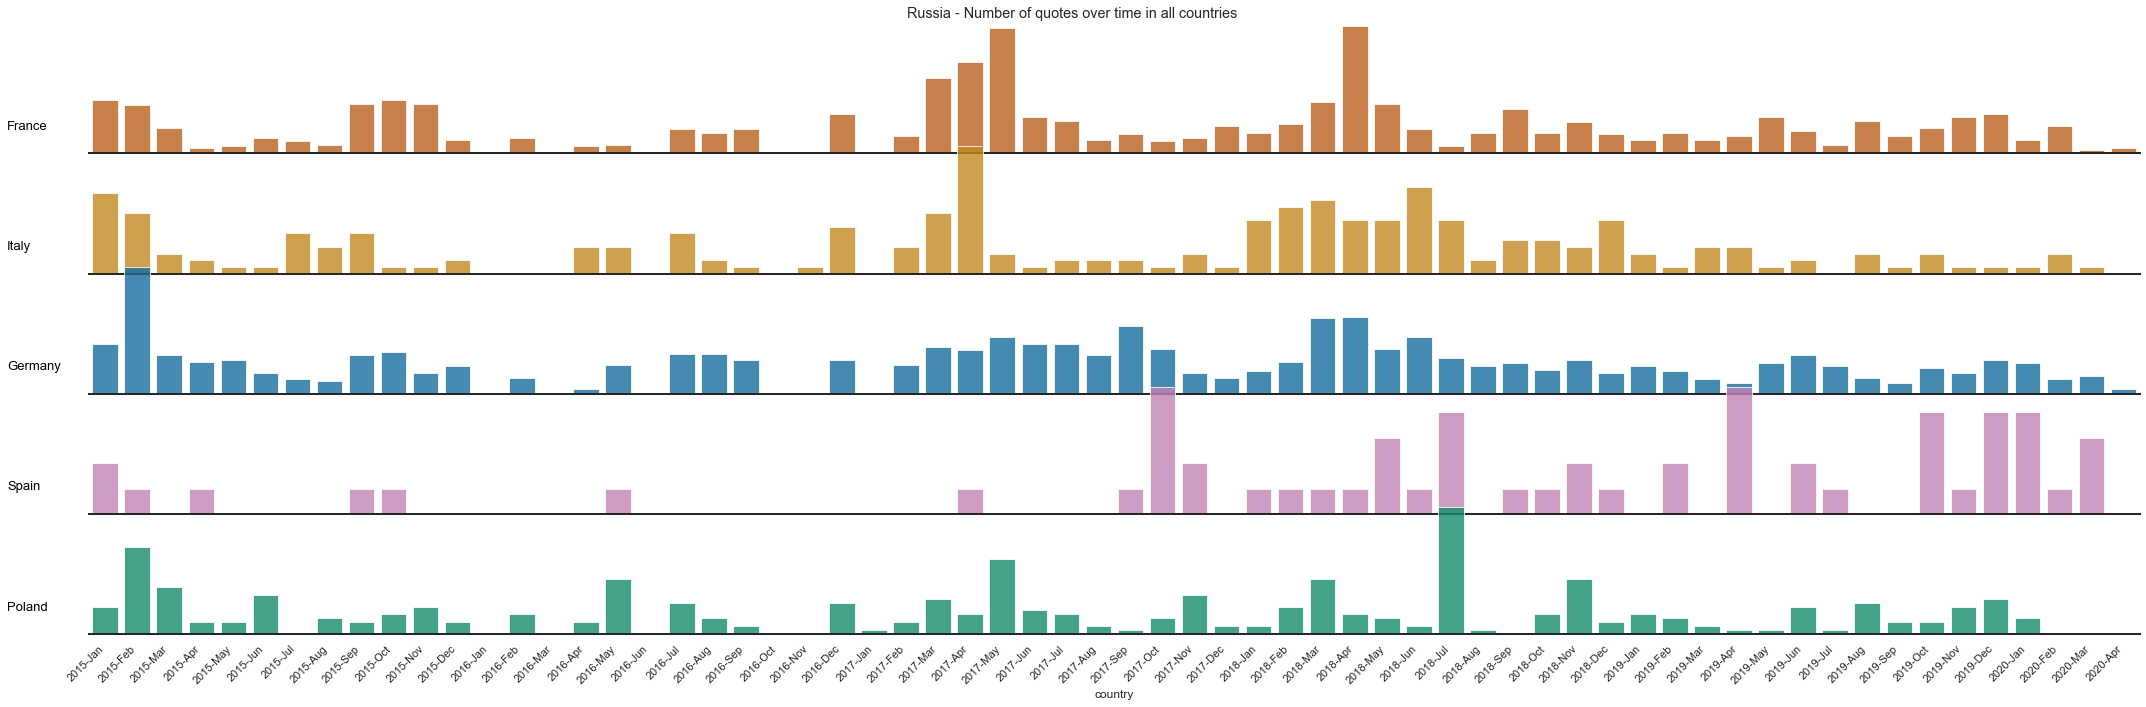

In [38]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

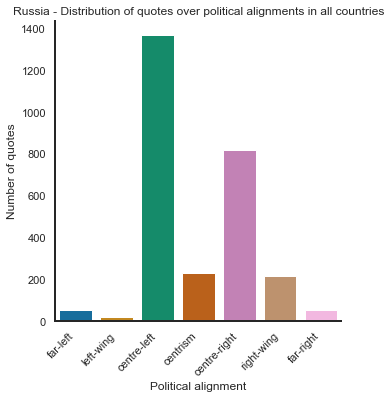

In [39]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

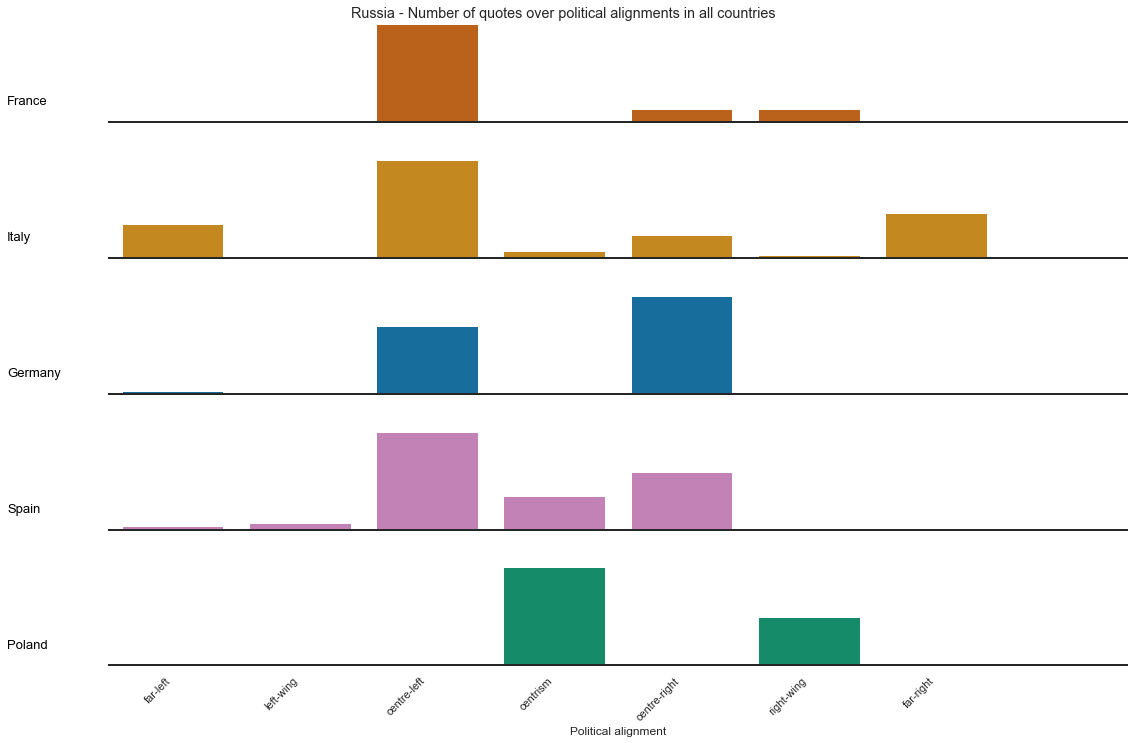

In [40]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

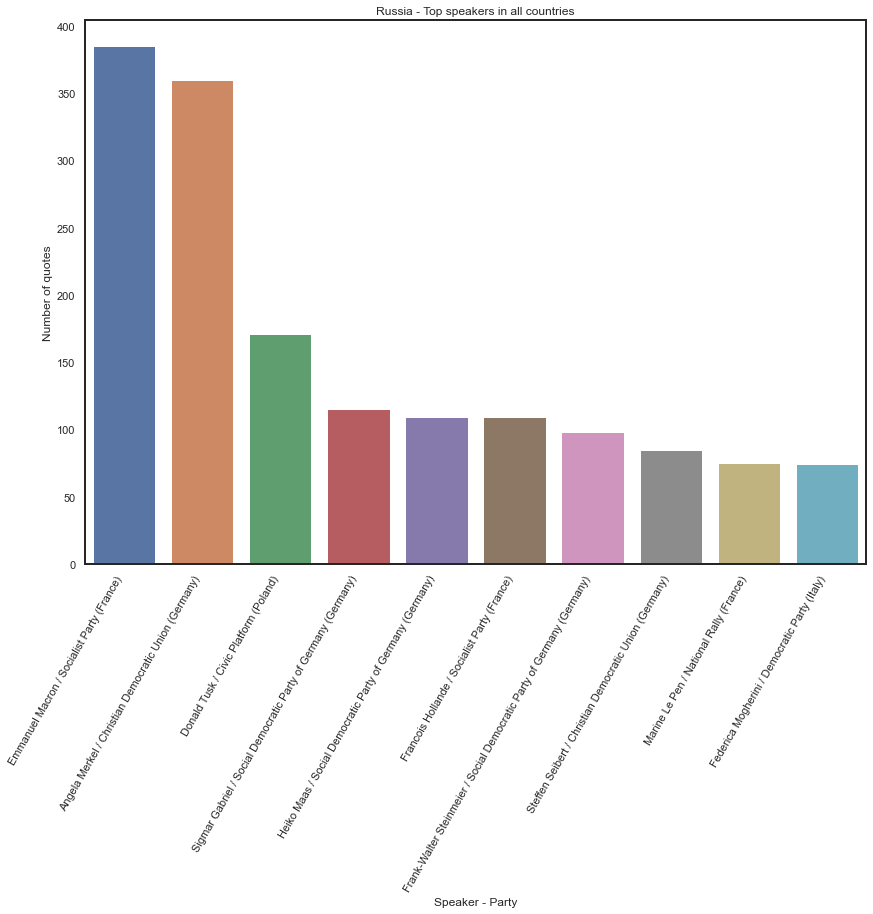

In [41]:
show_top_k_speakers(topic_name, df)


## Coronavirus

### Distribution over time in all countries

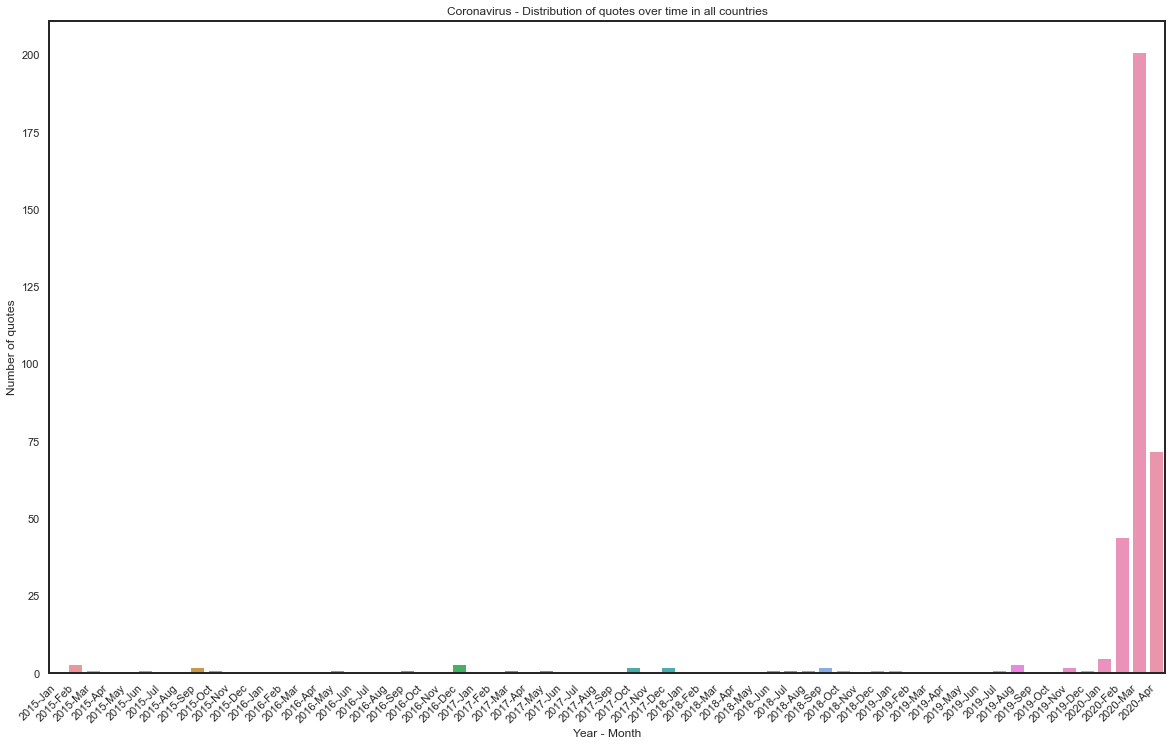

In [42]:
topic_name = 'Coronavirus'
df = covid_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

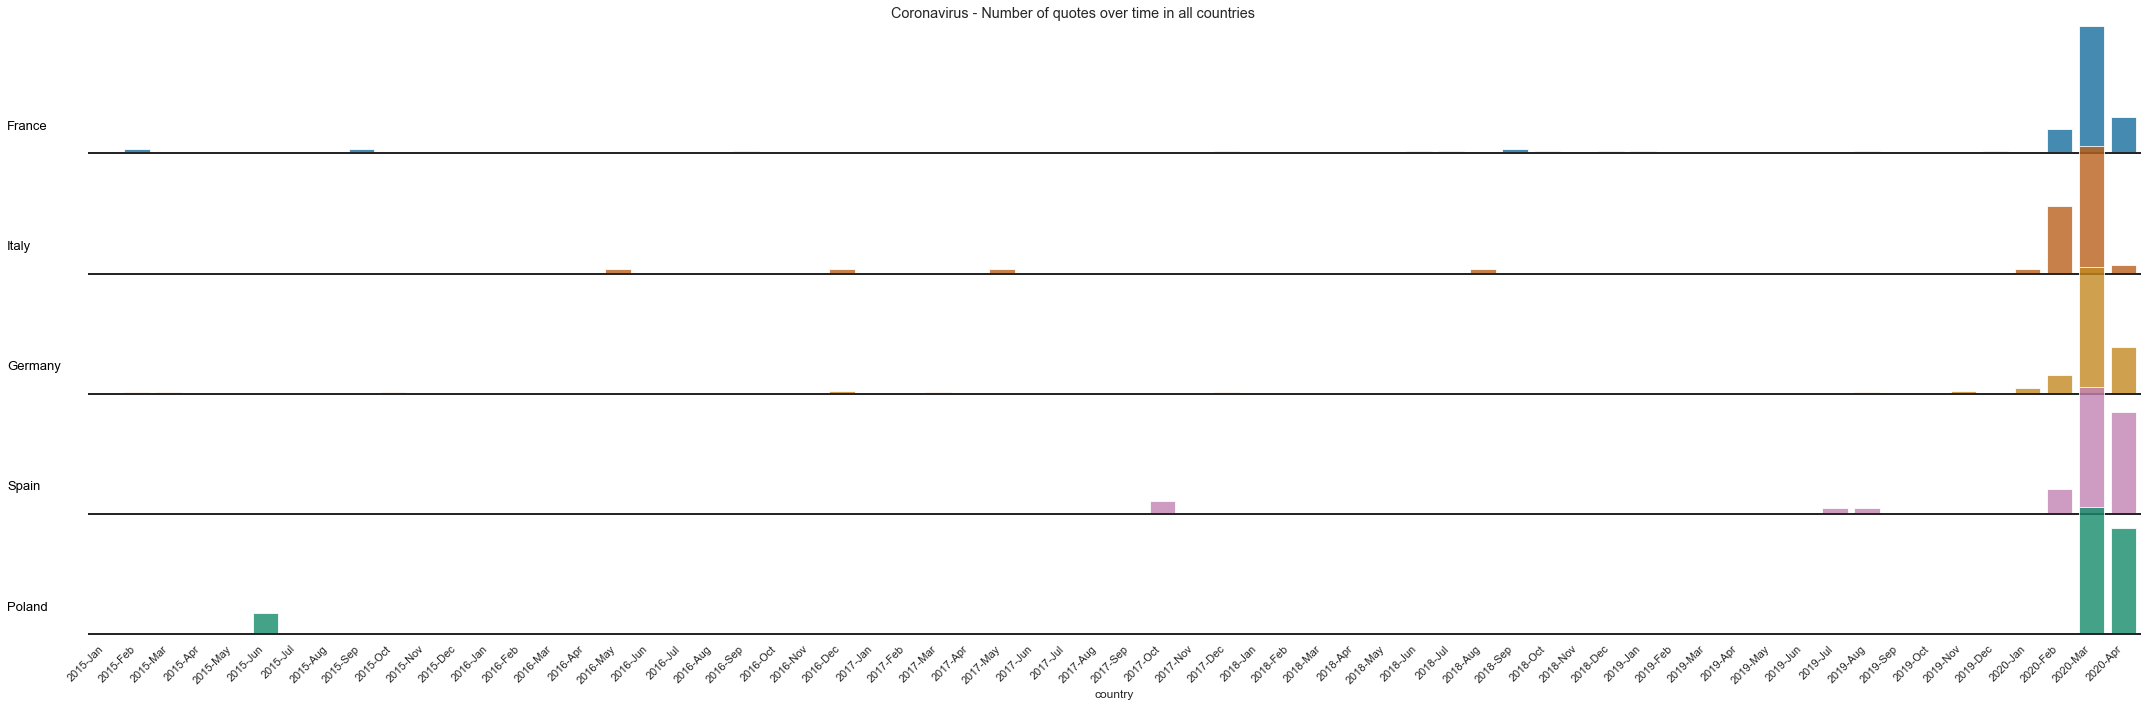

In [43]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

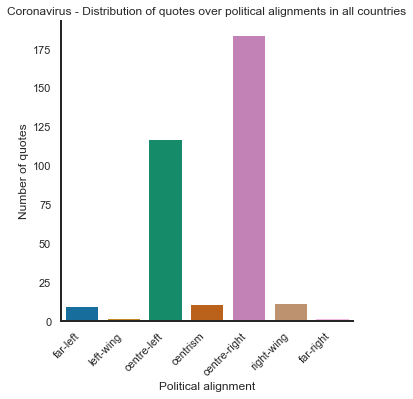

In [44]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

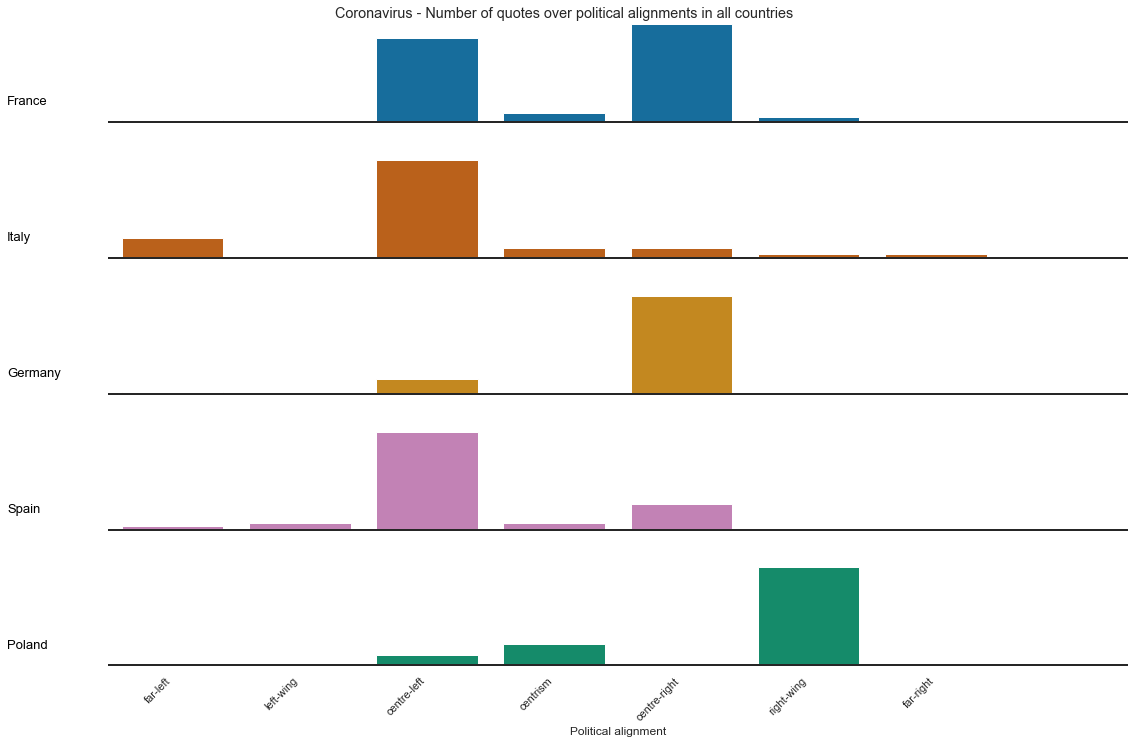

In [45]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

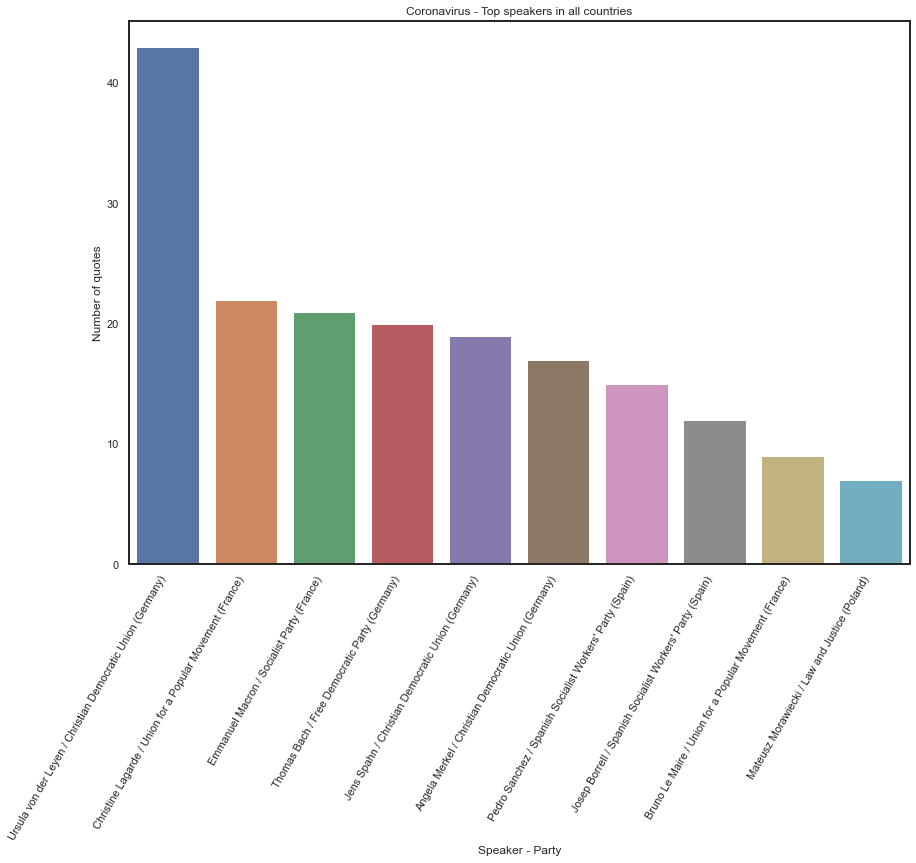

In [46]:
show_top_k_speakers(topic_name, df)

## Terrorism

### Distribution over time in all countries

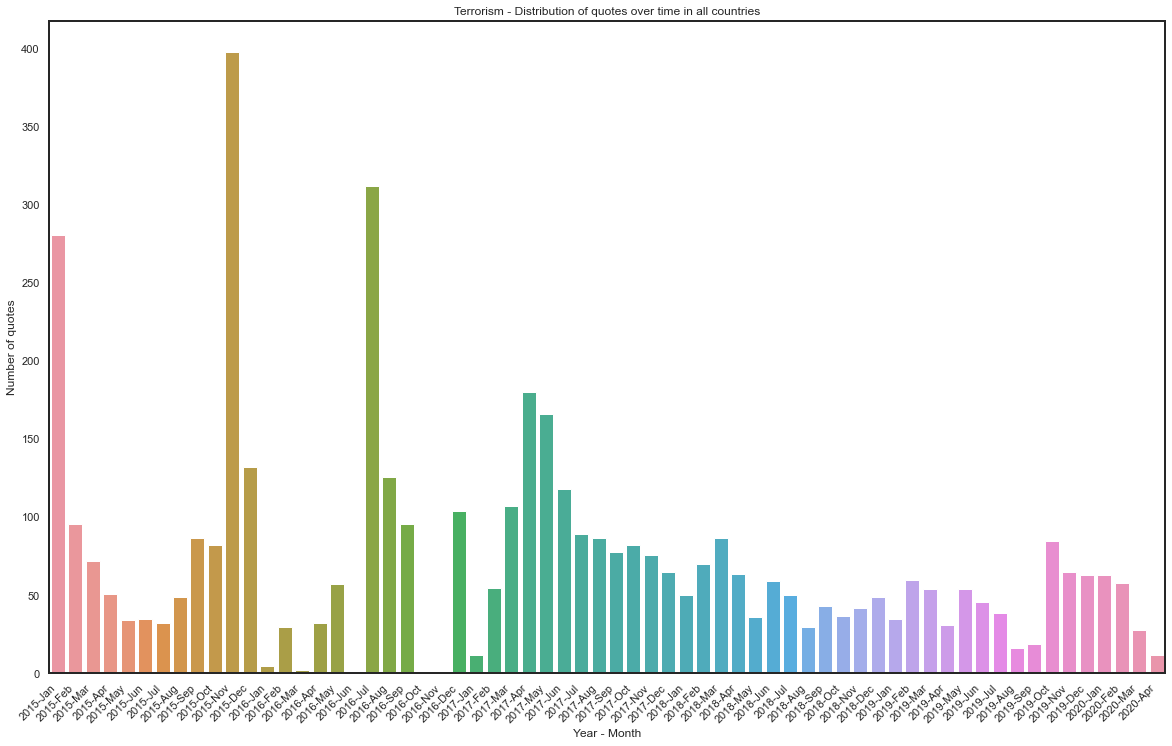

In [47]:
topic_name = 'Terrorism'
df = terrorism_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

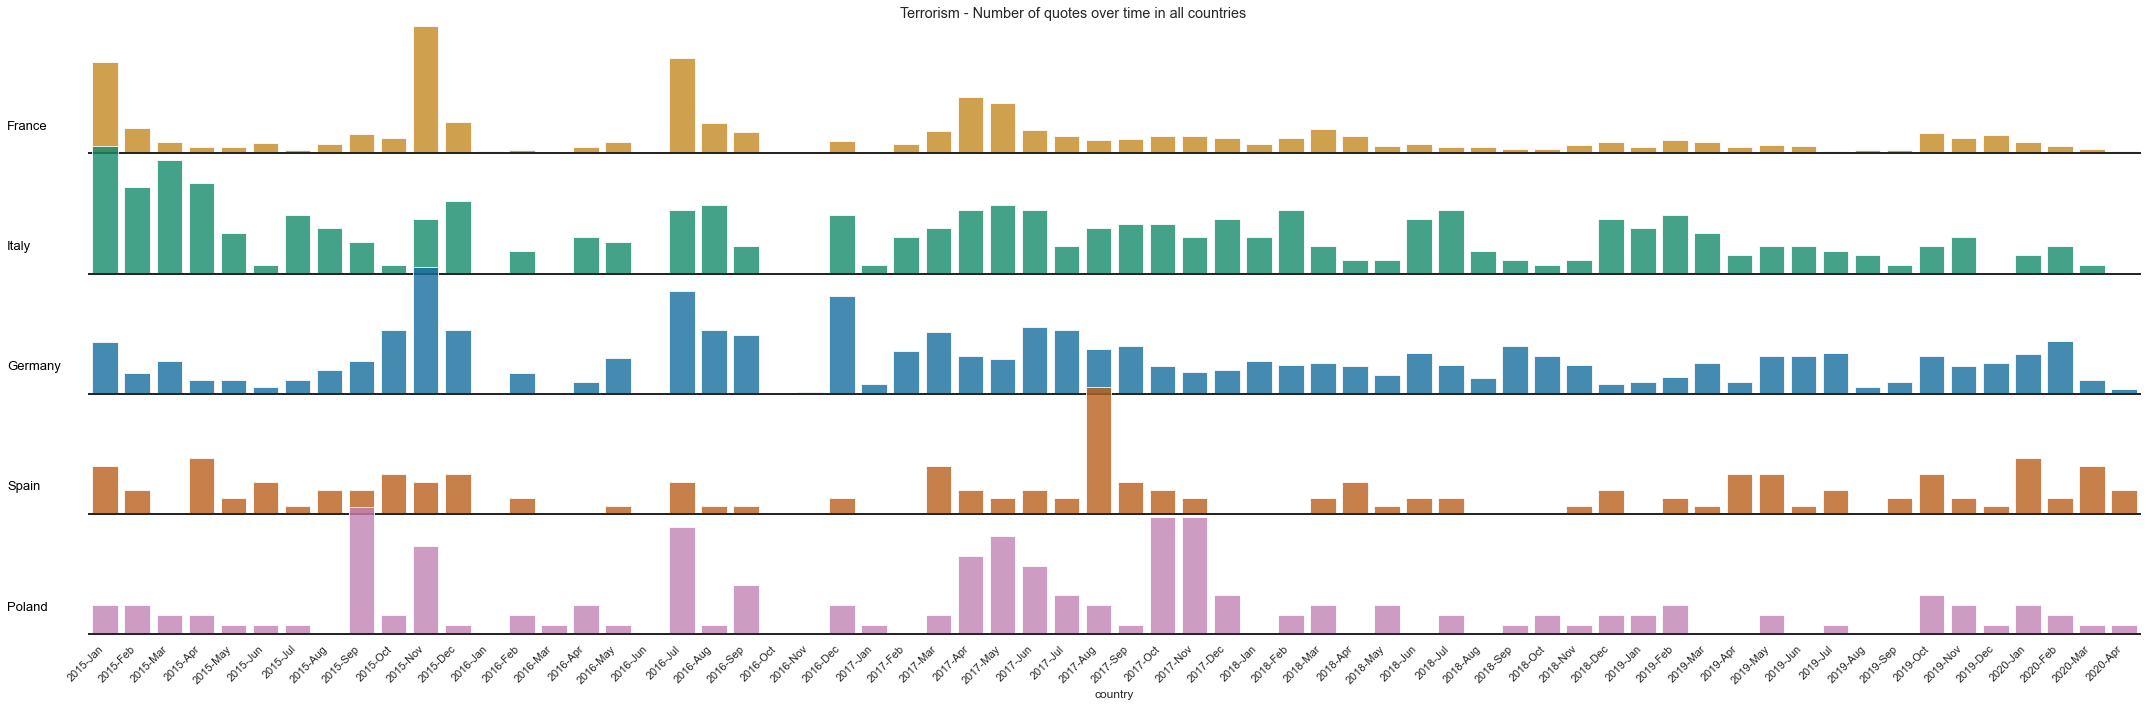

In [48]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

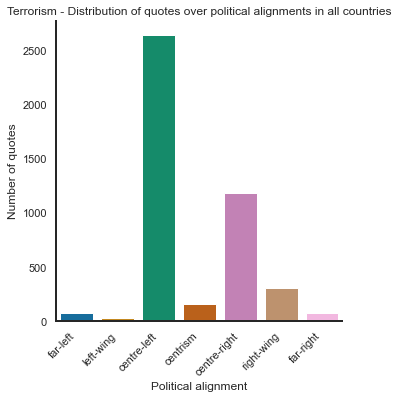

In [49]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

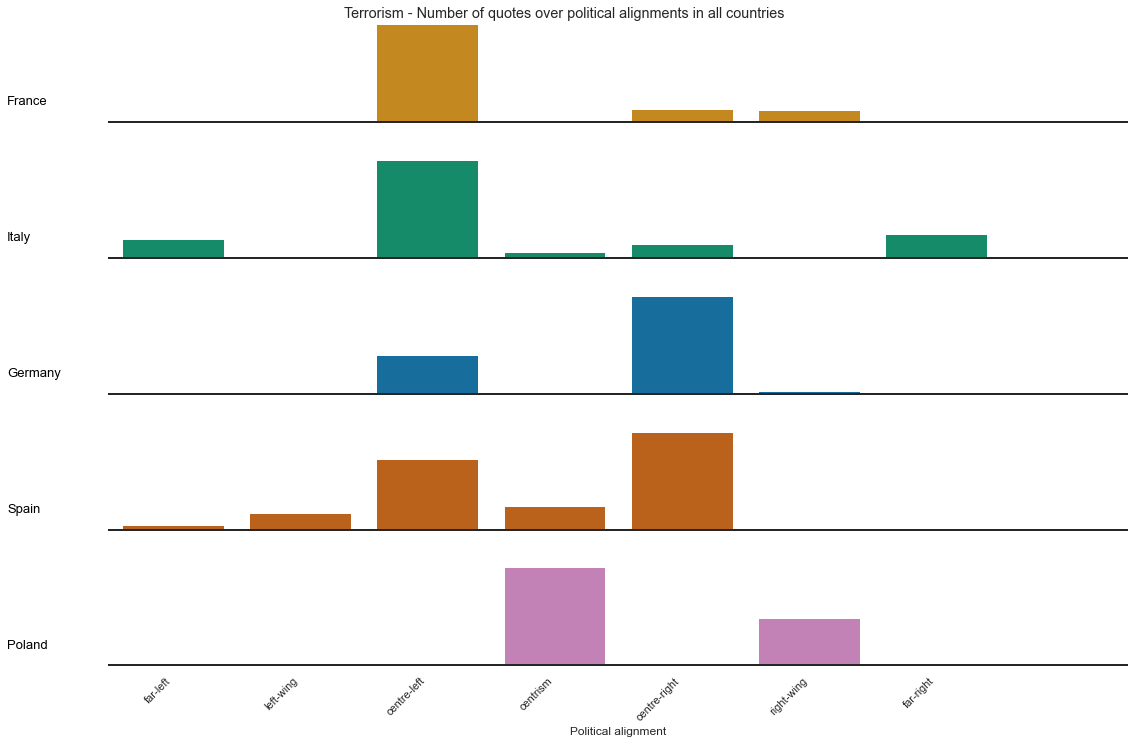

In [50]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

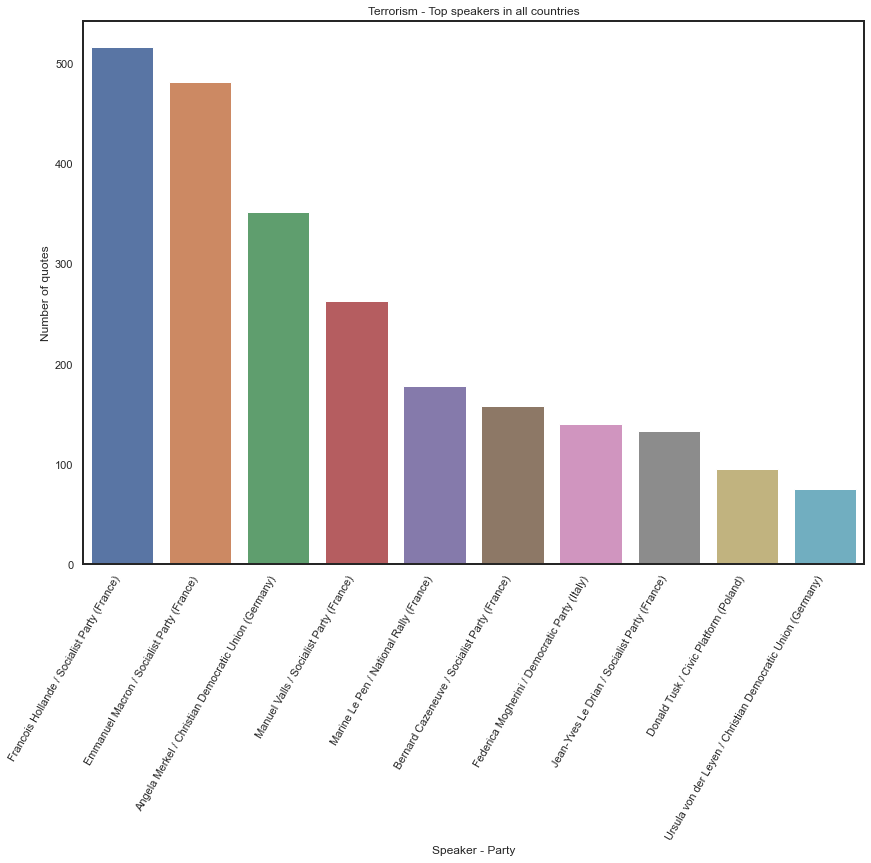

In [51]:
show_top_k_speakers(topic_name, df)

